# PROJECT: FEATURIZATION & MODEL TUNING
                                                                                        by ARYAN JAIN

## <span style="color:green">Apr 2021</span>

#### <span style="color:green">SUMMARY</span>
 
<b>Key Tasks:</b>
 - Import & explore the data
 - Data Cleansing
 - Data analysis & Visualization
 - Data pre-processing
 - Model training, testing & tuning

### <span>IMPORTING NECESSARY LIBRARIES</span>

#### Libraries for Data Management and Vizualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Data Normalization

In [2]:
from scipy.stats import zscore

#### Over/Under Sampling

In [3]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler

#### Model Building

In [4]:
from sklearn.model_selection import train_test_split

#### Models

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#### Ensemble Techniques

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#### Hyper Tuning

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

#### Scoring the models

In [8]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#### Other/Miscellaneous Libraries

In [9]:
# Library to pickle the model
import pickle

# Library to manage warnings outputted by kernel
import warnings

### Settings for the notebook

In [10]:
# display all columns when printing a pandas dataframe
pd.options.display.max_columns = None

# Ignore warnings given by the kernel
warnings.filterwarnings("ignore")

# Display all plots in the notebook itself without having to use plt.show()
%matplotlib inline

### <span>DEFINING CUSTOM FUNCTIONS</span>

##### I will plan to use these reusable functions for all my projects where applicable. Also I will create a custom library of such functions.

In [11]:
# Function to print performance report

def get_model_performance(model, X_train, y_train, X_test, y_test, y_pred):
    print("\n********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********\n")
    print("---------------------------------------------------------------------\n")
    train_acc = round(model.score(X_train , y_train), 3)
    test_acc = round(model.score(X_test , y_test), 3)
    print(f'\nAccuracy for train set: {round(train_acc, 3)}')
    print(f'Accuracy for test set: {round(test_acc, 3)}')
    print('\n\n')

    print(metrics.classification_report(y_test , y_pred))

    metrics.plot_confusion_matrix(model, X_test , y_test, values_format='d');
    
    
    precision = round(metrics.precision_score(y_test, y_pred), 3)
    recall = round(metrics.recall_score(y_test , y_pred), 3)
    f1 = round(metrics.f1_score(y_test , y_pred), 3)
    
    return train_acc, test_acc, precision, recall, f1

In [12]:
# Function to run K-Fold Cross Validation

def run_cv_kfold(model, X, y, num_folds=5, seed=7):
    
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

    print('\nModel Type: ',model)
    print("\n\n********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********\n")
    print("------------------------------------------------------------------------\n")
    print("\nRecall (Mean: K-fold):")
    cv_recall = np.mean(cross_val_score(model, X, y, cv=kfold, scoring='recall'))
    print(cv_recall)
    
    print("\nF1-score (Mean: K-fold):")
    cv_f1 = np.mean(cross_val_score(model, X, y, cv=kfold, scoring='f1'))
    print(cv_f1)
    
    print("\nAccuracy (Mean: K-fold):")
    cv_acc = np.mean(cross_val_score(model, X, y, cv=kfold, scoring='accuracy'))
    print(cv_acc)
    
    print("\nPrecision (Mean: K-fold):")
    cv_precision = np.mean(cross_val_score(model, X, y, cv=kfold, scoring='precision'))
    print(cv_precision)
       
    return cv_acc , cv_recall , cv_precision , cv_f1

In [13]:
# Function to update the performance summary

def update_performance_summary(perf_summary_df, model_name, sample_strategy, tech, train_acc, test_acc, recall, f1, precision, cv_acc , cv_recall , cv_f1, cv_precision):
    
    new_summary = perf_summary_df.copy()

    new_summary.loc[len(new_summary.index)] = [model_name, tech, sample_strategy, train_acc, test_acc, recall, f1, precision]
    if tech != "None":
        new_summary.loc[len(new_summary.index)] = [model_name, f"{tech} - KFold", sample_strategy, "CV - N/A", cv_acc , cv_recall , cv_f1, cv_precision]
    else:
        new_summary.loc[len(new_summary.index)] = [model_name, "KFold", sample_strategy, "CV - N/A", cv_acc , cv_recall , cv_f1, cv_precision]
    return new_summary

In [14]:
# Function that compiles all other custom function into a single line call

def run_model(perf_summary_df, X_train, X_test, y_train, y_test, model, model_name, sample_strat, 
              tech="None", num_folds=5, seed=7):

    X_k = X_train
    y_k = y_train

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Running custom function to get Cross Validation scores and printing performance
    cv_acc , cv_recall , cv_precision , cv_f1 = run_cv_kfold(model, X_k, y_k, num_folds, seed)
    
    # Running custom function to get model performance on metrics without Cross Validation
    train_acc, test_acc, precision, recall, f1 = get_model_performance(model, X_train, y_train, X_test, y_test, y_pred)


    perf_summary_df = update_performance_summary(perf_summary_df, model_name, sample_strat, tech, train_acc, 
                                                 test_acc, recall, f1, precision, cv_acc , cv_recall , cv_f1, 
                                                 cv_precision)
    
    return perf_summary_df

#### 1. IMPORT DATA & BASIC EXPLORATION

##### Read given datasets, Explore shape & size

In [15]:
# data files
trn_tst_fn = 'signal-data.csv'        
unseen_pred_fn = 'Future_predictions.xlsx'

In [16]:
# Reading the source data file and checking the first five rows
df = pd.read_csv(trn_tst_fn)
df.head()

,Time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,-0.0034,0.9455,202.4396,0.0,7.9558,414.8710,10.0433,0.9680,192.3963,12.5190,1.4026,-5419.00,2916.50,-4043.75,751.00,0.8955,1.7730,3.0490,64.2333,2.0222,0.1632,3.5191,83.3971,9.5126,50.6170,64.2588,49.3830,66.3141,86.9555,117.5132,61.29,4.515,70.0,352.7173,10.1841,130.3691,723.3092,1.3072,141.2282,1.0,624.3145,218.3174,0.0,4.592,4.841,2834.0,0.9317,0.9484,4.7057,-1.7264,350.9264,10.6231,108.6427,16.1445,21.7264,29.5367,693.7724,0.9226,148.6009,1.0,608.1700,84.0793,NaN,NaN,0.0,0.0126,-0.0206,0.0141,-0.0307,-0.0083,-0.0026,-0.0567,-0.0044,7.2163,0.1320,NaN,2.3895,0.9690,1747.6049,0.1841,8671.9301,-0.3274,-0.0055,-0.0001,0.0001,0.0003,-0.2786,0.0,0.3974,-0.0251,0.0002,0.0002,0.1350,-0.0042,0.0003,0.0056,0.0000,-0.2468,0.3196,NaN,NaN,NaN,NaN,0.9460,0.0,748.6115,0.9908,58.4306,0.6002,0.9804,6.3788,15.88,2.639,15.94,15.93,0.8656,3.353,0.4098,3.188,-0.0473,0.7243,0.9960,2.2967,1000.7263,39.2373,123.0,111.3,75.2,46.2000,350.6710,0.3948,0.0,6.78,0.0034,0.0898,0.0850,0.0358,0.0328,12.2566,0.0,4.271,10.284,0.4734,0.0167,11.8901,0.41,0.0506,NaN,NaN,1017.0,967.0,1066.0,368.0,0.090,0.048,0.095,2.0,0.9,0.069,0.046,0.7250,0.1139,0.3183,0.5888,0.3184,0.9499,0.3979,0.160,0.0,0.0,20.95,0.333,12.49,16.713,0.0803,5.72,0.0,11.19,65.363,0.0,0.0,0.0,0.0,0.0,0.0,0.292,5.38,20.10,0.296,10.62,10.30,5.38,4.040,16.230,0.2951,8.64,0.0,10.30,97.314,0.0,0.0772,0.0599,0.0700,0.0547,0.0704,0.0520,0.0301,0.1135,3.4789,0.0010,NaN,0.0707,0.0211,175.2173,0.0315,1940.3994,0.0,0.0744,0.0546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0027,0.0040,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0188,0.0,219.9453,0.0011,2.8374,0.0189,0.0050,0.4269,0.0,0.0,0.0,0.0,0.0,0.

In [17]:
# Reading the unseen dataset into a pandas dataframe and printing the first five rows
df2 = pd.read_excel(unseen_pred_fn)
df2.head(5)

,Time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100,97.6133,0.1242,1.5005,0.0162,-0.0034,0.9455,202.4396,0,7.9558,414.8710,10.0433,0.9680,192.3963,12.5190,1.4026,-5419.00,2916.50,-4043.75,751.00,0.8955,1.7730,3.0490,64.2333,2.0222,0.1632,3.5191,83.3971,9.5126,50.6170,64.2588,49.3830,66.3141,86.9555,117.5132,61.29,4.515,70,352.7173,10.1841,130.3691,723.3092,1.3072,141.2282,1,624.3145,218.3174,0,4.592,4.841,2834,0.9317,0.9484,4.7057,-1.7264,350.9264,10.6231,108.6427,16.1445,21.7264,29.5367,693.7724,0.9226,148.6009,1,608.1700,84.0793,NaN,NaN,0,0.0126,-0.0206,0.0141,-0.0307,-0.0083,-0.0026,-0.0567,-0.0044,7.2163,0.1320,NaN,2.3895,0.9690,1747.6049,0.1841,8671.9301,-0.3274,-0.0055,-0.0001,0.0001,0.0003,-0.2786,0,0.3974,-0.0251,0.0002,0.0002,0.1350,-0.0042,0.0003,0.0056,0.0000,-0.2468,0.3196,NaN,NaN,NaN,NaN,0.9460,0,748.6115,0.9908,58.4306,0.6002,0.9804,6.3788,15.88,2.639,15.94,15.93,0.8656,3.353,0.4098,3.188,-0.0473,0.7243,0.9960,2.2967,1000.7263,39.2373,123,111.3,75.2,46.2000,350.6710,0.3948,0,6.78,0.0034,0.0898,0.0850,0.0358,0.0328,12.2566,0,4.271,10.284,0.4734,0.0167,11.8901,0.41,0.0506,NaN,NaN,1017,967,1066,368,0.090,0.048,0.095,2.0,0.9,0.069,0.046,0.7250,0.1139,0.3183,0.5888,0.3184,0.9499,0.3979,0.160,0,0,20.95,0.333,12.49,16.713,0.0803,5.72,0,11.19,65.363,0,0,0,0,0,0,0.292,5.38,20.10,0.296,10.62,10.30,5.38,4.040,16.230,0.2951,8.64,0,10.30,97.314,0,0.0772,0.0599,0.0700,0.0547,0.0704,0.0520,0.0301,0.1135,3.4789,0.0010,NaN,0.0707,0.0211,175.2173,0.0315,1940.3994,0,0.0744,0.0546,0,0,0,0,0,0,0,0,0,0.0027,0.0040,0,0,0,0,NaN,NaN,NaN,NaN,0.0188,0,219.9453,0.0011,2.8374,0.0189,0.0050,0.4269,0,0,0,0,0,0,0,0,0,0,0,0.0472,40.855,4.5152,30.9815,33.9606,22.9057,15.9525,110.2144,0.1310,0,2.5883,0.0010,0.0319,0.01

In [18]:
# both data files contain same features
# we will build the best performing model using the train and test data, and use this to predict target variable
# for unseen data

In [19]:
# Let's take a quick look at all the information on the dataset, will investigate each part deeper in next steps
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


**OBSERVATIONS:**
* `We can see that all the independent variables, other than Time (object datatype) are floats (decimal datatype)`
* `The target variable (Pass/Fail) takes on only integer values`

In [20]:
# Explore shape & size
print('\n\n*** File: signal-data.csv***')
print(f'Number of rows   : {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

print('\n\n*** File: Future_predictions.xlsx ***')
print(f'Number of rows   : {df2.shape[0]}')
print(f'Number of columns: {df2.shape[1]}')



*** File: signal-data.csv***
Number of rows   : 1567
Number of columns: 592


*** File: Future_predictions.xlsx ***
Number of rows   : 18
Number of columns: 591


In [21]:
# Let's take closer look at the dataset, checking data types of each column

df.dtypes

Time          object
0            float64
1            float64
2            float64
3            float64
              ...   
586          float64
587          float64
588          float64
589          float64
Pass/Fail      int64
Length: 592, dtype: object

**OBSERVATIONS:**
* `As expected, all the independent features for signal data and are numeric, with the exceptions of Time and Pass/Fail`
* `We will investigate Time if any relation with the distribution of target variable`
* `We will perform detailed analysis for features selection`

In [22]:
# Basic stats for Numerical attributes, including Five point summary

df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,Pass/Fail
count,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1564.0,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1557.000000,1567.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1543.000000,1543.000000,1566.0,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.0,1566.000000,1566.000000,1566.0,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000,1560.000000,1561.000000,1561.000000,1561.000000,1560.000000,1560.000000,1560.000000,1561.000000,1561.000000,1561.000000,1561.0,1561.000000,1561.000000,773.000000,773.000000,1561.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,1566.000000,1555.000000,226.000000,1567.000000,1567.000000,1567.000000,1516.000000,1516.000000,1561.000000,1565.000000,1565.000000,1561.000000,1561.000000,1561.000000,1561.0,1561.000000,1561.00000,1561.000000,1561.000000,1561.000000,1565.000000,1565.000000,1561.000000,1561.000000,1561.000000,1561.000000,549.000000,549.000000,549.000000,852.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1543.000000,1567.000000,1567.000000,1558.000000,1558.00000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1559.000000,1559.000000,1559.000000,1562.000000,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.0

In [23]:
# In following steps, we will refer to some of these stats.

#### 2. DATA CLEANSING

##### Missing values, Data quality checks & Cleansing observations

In [24]:
# Missing values check
df.isnull().any().any()

True

**OBSERVATION:**
* `The dataset has missing values`

In [25]:
df.isnull().sum().sum()

41951

In [26]:
# The significant number of null values warrants close look.

In [27]:
# Checking how many rows have null values to see if dropping them will have a significant impact on the data

df.isnull().any(axis=1).sum()

1567

In [28]:
# Every row has at least 1 missing value, so dropping the rows with missing values is NOT an option

# Let's take a closer look at missing values distribution

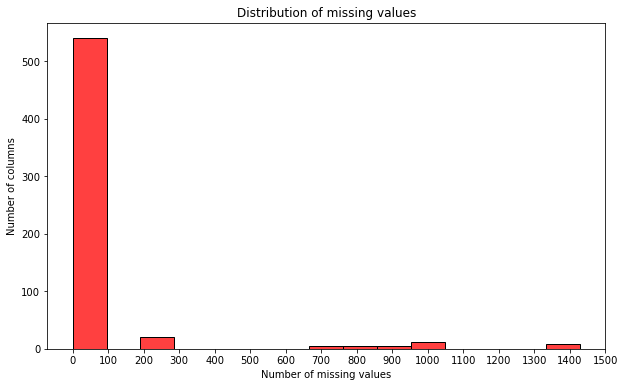

In [29]:
# Visualize number of missing values vs. number of columns 

num_missing = []
for col in df.columns:
    num_missing.append(df[col].isnull().sum())


plt.figure(figsize=(10, 6))
sns.histplot(num_missing, bins=15, color='r')
plt.title("Distribution of missing values")
plt.xlabel("Number of missing values")
plt.ylabel("Number of columns")
plt.xticks(range(0, 1501, 100)) # Using 1501 so we get the 1500 xtick as well
plt.show()

**OBSERVATIONS:**
* `The data represents measurements from a large number of processes or sensors`
* `Significant number of missing values, >50% of a column in 2% of the cases`

**`Let's handle missing values now.`**

In [30]:
# Based on plot, looks like majority of features have less than 100 missing values
# Few features have > 200 missing values and some > 700 missing values
# Some columns have around 90% missing values!!!!
# I will drop columns having more than 200 missing values.

In [31]:
df_orig = df.copy() # saving a copy of original dataframe
df_orig.shape

(1567, 592)

In [32]:
# drop columns having more than 200 missing values

num_cols_200 = 0
for col in df.columns:
    if df[col].isnull().sum() > 200:
        df.drop(col, axis=1, inplace=True)

print('Number of features after dropping columns with more than 200 missing entries:\n {}'\
.format(df.shape[1]))

Number of features after dropping columns with more than 200 missing entries:
 540


In [33]:
# Checking data types distribution of features in the dataset:
    
df.dtypes.value_counts()

float64    538
object       1
int64        1
dtype: int64

In [34]:
# Checking field with object data type

obj_cols = [col for col in df.columns if df[col].dtype == "object"]
obj_cols

['Time']

In [35]:
# checking values in Time field

df['Time'].nunique()

1534

**OBSERVATIONS:**
* `Time column appears to be an indicator of when measurements were taken, it does not provide predictor value`
* ` I will drop Time column since it has no predictor value.`

In [36]:
# Dropping Time column, it has no predictor value as explained above.
df.drop("Time", axis=1, inplace=True)

In [37]:
# remove columns having identical values in each row
# Logic used: std. dev is 0 means all values are the same, thus giving us no extra predictive power

for col in df.columns:
    std_dev = df[col].std()
    if std_dev == 0:
        df.drop(col, axis=1, inplace=True)

print('No. of remaining features:\n {}'\
.format(df.shape[1]))

No. of remaining features:
 423


In [38]:
# Impute the remainaing missing values with the median for the column.

df.fillna(df.median(), inplace=True)
df.isnull().values.any() # confirming no missing values

False

In [39]:
# No missing value after imputation

In [40]:
# I will check correlation of each feature with the target
# Drop features having low correlation with the target (I am setting low corr < 0.01).
# Such features dont have meaningful predictor value

for col in df.columns:
    if df[col].corr(df['Pass/Fail']) < 0.01:
        df.drop(col, axis=1, inplace=True)

print(f'No. of remaining features:\n{df.shape[1]}')

No. of remaining features:
186


In [41]:
# Correlation between indepndent variables, will drop if > 0.99 correlation.

for col in df.drop("Pass/Fail", axis=1).columns:
    try:
        for column in df.drop([col, "Pass/Fail"], axis=1).columns:
            try:
                if df[col].corr(df[column]) > 0.99:
                    df.drop(column, axis=1, inplace=True)
            except:
                pass
    except:
        pass

print(f'No. of remaining features:\n{df.shape[1]}')

No. of remaining features:
151


In [42]:
df_base = df.copy() # saving copy
df_base.shape

(1567, 151)

In [43]:
df_base.head()

,6,7,8,10,19,20,21,23,29,30,32,33,37,38,47,54,56,58,59,61,63,64,65,67,75,79,81,86,88,89,93,95,99,100,103,114,121,123,124,126,128,129,130,131,133,136,137,138,153,159,160,163,164,165,166,167,170,172,175,183,188,195,196,197,198,199,200,201,202,203,204,205,207,210,211,213,216,217,219,221,222,224,225,227,228,238,249,253,269,271,272,273,282,301,302,305,307,310,319,324,331,332,333,334,335,336,337,339,340,343,348,349,357,359,363,365,366,376,388,406,407,419,423,425,430,431,433,434,438,460,471,474,476,477,486,489,500,510,511,521,522,541,544,558,559,560,561,582,587,588,Pass/Fail
0,97.6133,0.1242,1.5005,-0.0034,12.5190,1.4026,-5419.00,-4043.75,2.0222,0.1632,83.3971,9.5126,66.3141,86.9555,1.3072,4.841,0.9317,4.7057,-1.7264,10.6231,16.1445,21.7264,29.5367,0.9226,0.0126,-0.0083,-0.0567,2.3895,1747.6049,0.1841,-0.0001,0.0003,-0.0251,0.0002,-0.0042,0.0,15.88,15.94,15.93,3.353,3.188,-0.0473,0.7243,0.9960,1000.7263,111.3,75.2,46.2000,0.0167,1017.0,967.0,0.090,0.048,0.095,2.0,0.9,0.7250,0.3183,0.9499,16.713,65.363,0.292,5.38,20.10,0.296,10.62,10.30,5.38,4.040,16.230,0.2951,8.64,10.30,0.0772,0.0599,0.0547,0.0301,0.1135,0.0010,0.0707,0.0211,0.0315,1940.3994,0.0744,0.0546,0.0027,0.0,0.0189,4.5152,33.9606,22.9057,15.9525,0.0109,0.6083,0.3032,0.2827,0.1342,0.3670,5.3737,18.0118,0.0752,1.5989,6.5893,0.0913,3.0911,8.4654,1.5989,5.3406,0.0867,2.9971,0.0215,0.0274,0.0004,0.0229,560.2658,0.0170,0.0148,0.0010,61.5932,14.2396,1.4392,0.0000,53.6840,4.7141,18.7673,33.1562,49.0013,10.0503,44.5055,29.9394,9.7752,13.6778,31.9893,5.8142,843.1138,0.0000,0.0000,64.6707,0.0000,0.0,29.3804,11.5074,0.0026,1.0344,0.4385,0.1039,42.3877,0.5005,0.0148,0.0046,-1
1,102.3433,0.1247,1.4966,-0.0148,12.4608,1.3825,-5441.50,-3498.75,2.2667,0.2102,84.9052,9.7997,64.9193,87.5241,1.2887,4.842,0.9324,4.6820,0.8073,10.3092,10.9036,19.1927,27.6301,1.1598,-0.0039,-0.0358,-0.0377,2.3754,1931.6464,0.1874,0.0000,0.0001,-0.0158,-0.0004,-0.0045,0.0,15.88,15.91,15.88,2.771,3.272,-0.0946,0.8122,0.9985,998.1081,80.3,81.0,56.2000,0.0144,568.0,59.0,0.112,0.115,0.124,2.2,1.1,1.0498,0.4115,1.0181,16.358,82.986,0.222,3.74,19.59,0.316,11.65,8.02,3.74,3.659,15.078,0.3580,8.96,8.02,0.0566,0.0488,0.1578,0.0734,0.0747,0.0050,0.0761,0.0014,0.0238,1988.0000,0.0203,0.0236,0.0064,0.0,0.0187,3.6327,28.9862,22.3163,17.4008,0.0069,0.8151,0.3464,0.3814,0.1667,0.3752,5.2445,23.6230,0.0778,1.1506,5.9247,0.0878,3.3604,7.7421,1.1506,5.0108,0.1013,2.4890,0.0142,0.0230,0.0017,0.0248,677.1873,0.0053,0.0059,0.0022,65.0999,10.5837,1.0323,368.9713,61.8918,6.1188,10.4383,2.2655,199.7866,8.6336,48.5294,40.4475,10.2211,13.2430,30.8643,5.8042,130.6350,0.0000,0.0000,141.4365,0.0000,0.0,26.3970,9.5796,0.0026,0.9634,0.1745,0.0375,18.1087,0.5019,0.0201,0.0060,-1
2,95.4878,0.1241,1.4436,0.0013,12.5404,1.4123,-5447.75,-4047.00,2.3333,0.1734,84.7569,8.6590,65.8389,84.7327,1.2992,4.748,0.9139,4.5873,23.8245,10.1685,11.3019,16.1755,24.2829,0.8694,-0.0078,-0.0054,-0.0182,2.4532,1685.8514,0.1497,-0.0013,0.0002,0.1218,0.0006,-0.0026,0.0,15.90,15.94,15.95,3.094,3.272,-0.1892,0.8194,0.9978,998.4440,126.4,96.5,45.1001,0.0177,562.0,788.0,0.187,0.117,0.068,2.1,1.4,1.0824,0.3141,0.9677,22.912,60.110,0.139,5.09,19.75,0.949,9.71,16.73,5.09,11.059,22.624,0.1164,13.30,16.73,0.0339,0.0494,0.0406,0.0349,0.0718,0.0014,0.0963,0.0152,0.0284,839.6006,0.0192,0.0170,0.0062,0.0,0.0733,3.9133,41.3837,32.6256,15.7716,0.0075,0.6964,0.4031,0.3846,0.1288,0.3677,6.1797,16.0104,0.0243,1.5481,5.9453,0.2777,3.1600,8.9855,1.5481,6.2277,0.0353,5.6983,0.0105,0.0208,0.0005,0.0302,283.6616,0.0054,0.0043,0.0021,28.7334,11.4871,1.1798,0.0000,50.6425,5.2707,10.3162,29.1663,109.5747,14.2503,60.0000,32.3594,8.3977,45.5423,13.3923,9.1221,746.9150,250.1742,0.0000,240.7767,244.2748,0.0,14.5293,9.3046,0.0026,1.5021,0.3718,0.1233,24.7524,0.4958,0.0484,0.0148,1
3,104.2367,0.1217,1.4882,-0.0033,12.4782,1.4011,-5468.25,-4515.00,2.6444,0.2071,84.9105,8.6789,65.1951,86.6867,1.3027,4.748,0.9139,4.5873,24.3791,10.2112,13.5597,15.6209,23.4736,0.9761,-0.0555,0.0676,0.0028,2.4004,1752.0968

In [44]:
# The dataset still has large number of features. 
# I will check the importance or predictor value of features 

# I will use Random forests for features importance 

<span style="color:red"> Next steps:</span>
   - Calculating features importance using Random Forest
   - I will drop the features having importance < 0.01

In [45]:
# Let's set values for variables for repeatability 

seed = 7 # will use this for random_state
importance_threshold = 0.01 # meaninful predictor filter  

In [46]:
# Let's list features and importance scores above threshold value 

X = df.drop("Pass/Fail", axis=1)
y = df['Pass/Fail']

rf = RandomForestClassifier(n_estimators=100, min_impurity_decrease=0.0015, random_state=seed)
rf.fit(X, y)

# displaying features and their rank

importance = rf.feature_importances_
ranked_indices = np.argsort(importance)[::-1]
col_imp = []
print("Feature Rank:")
for i in range(40):
    print("{} ranked_column  {}  {}"\
    .format(i+1, df.columns[ranked_indices[i]], importance[ranked_indices[i]]))
    col_imp.append(df.columns[ranked_indices[i]])
print( "\n")
for i in range(len(importance)-5,len(importance)):
    print("{0:3d} ranked_column  {1:3d}  {2:6.4f}"\
    .format(i+1, ranked_indices[i], importance[ranked_indices[i]]))

navg = 0
for i in range(len(importance)):    
    if importance[ranked_indices[i]] > np.average(rf.feature_importances_):
        navg = navg+1
print( 'The number of features better than average is: {}'.format(navg))

Feature Rank:
1 ranked_column  64  0.033761452262876926
2 ranked_column  59  0.030708840693260568
3 ranked_column  65  0.021574665321713794
4 ranked_column  153  0.021031410009665116
5 ranked_column  477  0.018544298756113135
6 ranked_column  21  0.01832282261254321
7 ranked_column  205  0.017982111226920595
8 ranked_column  121  0.01553113674411117
9 ranked_column  431  0.01481841504350213
10 ranked_column  348  0.014661050319516518
11 ranked_column  333  0.014594052199092752
12 ranked_column  103  0.014520998181591128
13 ranked_column  425  0.013988140199112709
14 ranked_column  38  0.012870087477094932
15 ranked_column  197  0.011575535594766644
16 ranked_column  165  0.011262451612394954
17 ranked_column  81  0.011244455953295257
18 ranked_column  216  0.011105635834933405
19 ranked_column  63  0.011091149059049081
20 ranked_column  343  0.011071779768962009
21 ranked_column  203  0.010667417933824017
22 ranked_column  359  0.01058813533182974
23 ranked_column  282  0.0100694246945

In [47]:
# List the Features having importances > set threshold value

imp_value = list(importance)
imp_value.sort(reverse=True)
df_imp = pd.DataFrame([col_imp, imp_value], index=["col_name", "importance"]).T
df_imp=df_imp.loc[df_imp["importance"] >= importance_threshold]
df_imp

,col_name,importance
0,64,0.0337615
1,59,0.0307088
2,65,0.0215747
3,153,0.0210314
4,477,0.0185443
5,21,0.0183228
6,205,0.0179821
7,121,0.0155311
8,431,0.0148184
9,348,0.0146611


In [48]:
# Dropping the features that have importance less than set threshold value (0.01)

predictor_cols = list(df_imp['col_name'])

for col in df.columns[:-1]:
    if col not in predictor_cols:
        df.drop(col, axis=1, inplace=True)  
print('The number of features to use for model:', len(predictor_cols))

The number of features to use for model: 23


In [49]:
df.head()

,21,38,59,63,64,65,81,103,121,153,165,197,203,205,216,282,333,343,348,359,425,431,477,Pass/Fail
0,-5419.00,86.9555,-1.7264,16.1445,21.7264,29.5367,-0.0567,-0.0042,15.88,0.0167,0.095,20.10,16.230,8.64,0.0301,0.0109,6.5893,2.9971,0.0215,0.0229,4.7141,33.1562,5.8142,-1
1,-5441.50,87.5241,0.8073,10.9036,19.1927,27.6301,-0.0377,-0.0045,15.88,0.0144,0.124,19.59,15.078,8.96,0.0734,0.0069,5.9247,2.4890,0.0142,0.0248,6.1188,2.2655,5.8042,-1
2,-5447.75,84.7327,23.8245,11.3019,16.1755,24.2829,-0.0182,-0.0026,15.90,0.0177,0.068,19.75,22.624,13.30,0.0349,0.0075,5.9453,5.6983,0.0105,0.0302,5.2707,29.1663,9.1221,1
3,-5468.25,86.6867,24.3791,13.5597,15.6209,23.4736,0.0028,-0.0059,15.55,0.0150,0.100,23.60,24.320,9.56,0.0643,0.0063,6.6262,6.3292,0.0407,0.0252,13.4420,13.4051,6.4746,-1
4,-5476.25,86.1468,-12.2945,21.9782,32.2945,44.1498,-0.0123,-0.0045,15.75,0.0126,0.113,15.76,33.832,9.09,0.0924,0.0080,4.7279,6.3767,0.0246,0.0286,4.2892,10.7390,6.1979,-1


In [50]:
# Exporting feature names that I will use as predictors (23 FEATURES)

df_predictors = pd.DataFrame(predictor_cols, columns=["Column name"])
df_predictors.to_csv (r'predictor_columns.csv', index = False, header=True)

<span style="color:green"><b>STEPS COMPLETED:</b></span> 

    - FEATURES ENGINEERING
    - NULLS HANDLING
    - WEAK CORRELATION WITH TARGET
    - STRONG CORELATION WITHIN FEATURES
    - DATA CLEANSING 

#### 3. DATA ANALYSIS & VISUALISATION

In [51]:
# Target field distribution

x_pct = pd.DataFrame((df['Pass/Fail'].value_counts(normalize = True)*100).round(2)).reset_index()
x_cnt = pd.DataFrame(df['Pass/Fail'].value_counts()).reset_index()
x_cnt_pct = pd.merge(x_pct, x_cnt, right_index=True, left_index=True)
x_cnt_pct.drop('index_y', inplace=True, axis=1)

x_cnt_pct.columns =["Pass/Fail","%", "Count"]
x_cnt_pct.replace([-1, 1], ["Pass", "Fail"], inplace=True)
x_cnt_pct

,Pass/Fail,%,Count
0,Pass,93.36,1463
1,Fail,6.64,104


In [52]:
# The data file has class imbalance issues. We will take care of this during model training.

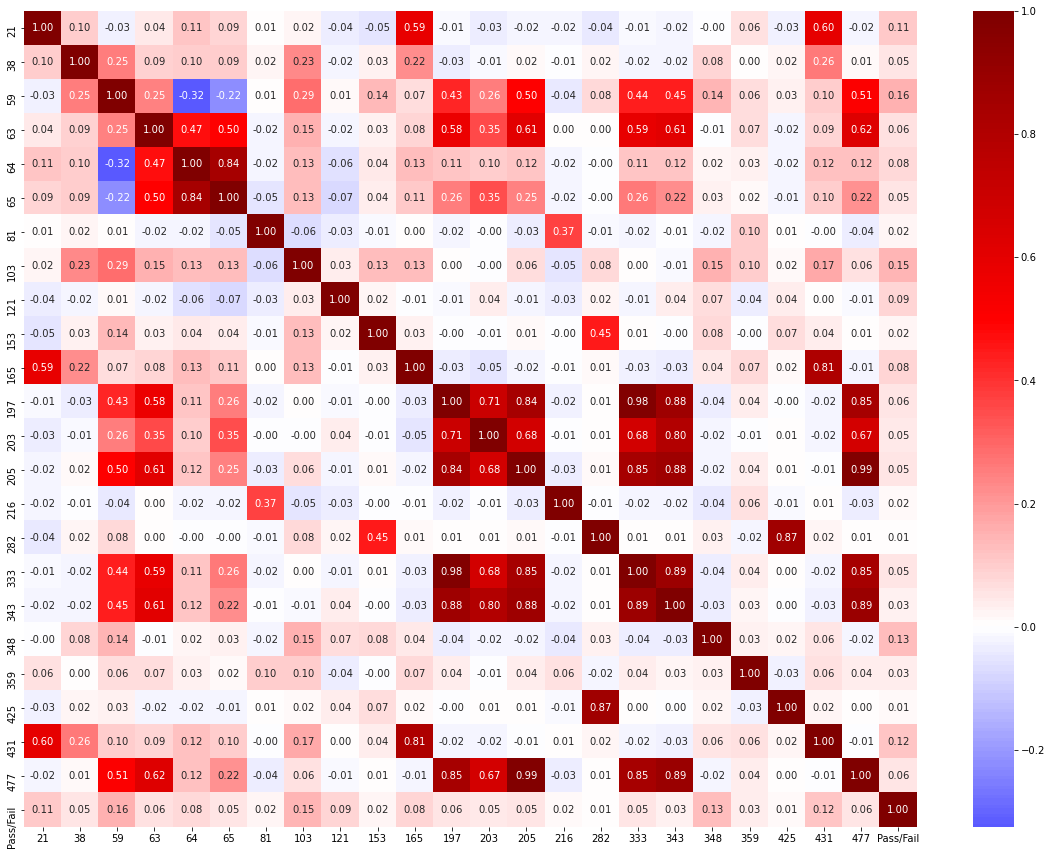

In [53]:
# Let's visualize using heatmap 

# Based on number of features, it's easier to visualize using heatmap compare to pairplot.
# I will use heatmap, and skip pairplot

plt.figure(figsize=(20, 15))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="seismic", center=0);

In [54]:
# Let's look at how many features have corr > 0.90

sort = corr.abs().unstack()
sort = sort.sort_values(kind = "quicksort", ascending = False)
sort[(sort > 0.9) & (sort < 1)]

205  477    0.986622
477  205    0.986622
197  333    0.982597
333  197    0.982597
dtype: float64

 ##### Observations
   - We already dropped features with high corr (>0.99)
   - based on above plot, only very few (2-3) features have corr between 0.95-0.99. 
   - I will not drop these features 

##### Let's check each features for outliers

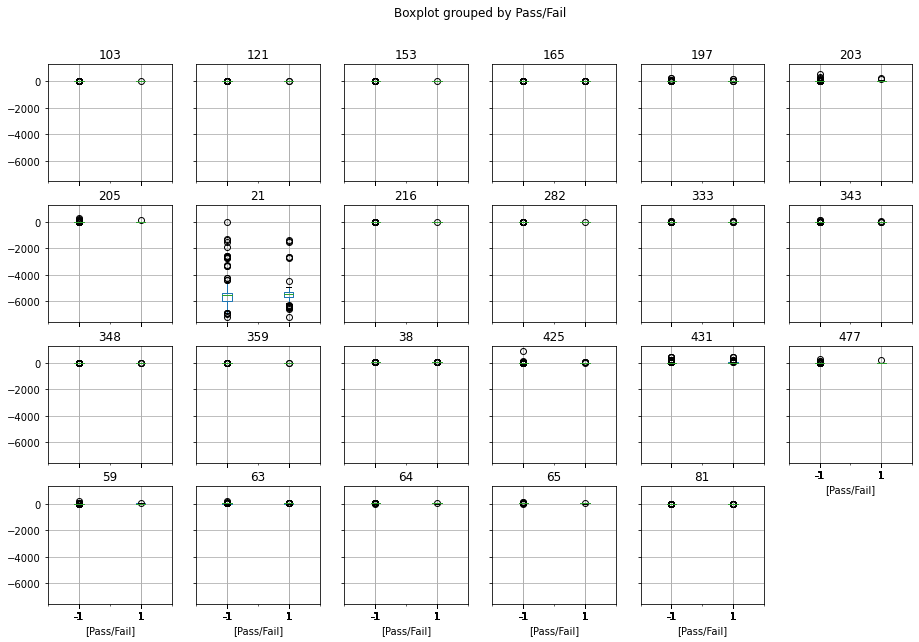

In [55]:
# Box plot for a quick sense of outliers

df.boxplot(by = 'Pass/Fail',  layout=(4,6), figsize=(15, 10));


In [56]:
# The box plot shows outliers for several features

In [57]:
# Addressing outliers using replace by median for data points > 2 std away from the mean
       
def replace(group):
    median, std = group.median(), group.std()  #Get the median and the standard deviation of every group 
    outliers = (group - median).abs() > 2*std # Subtract median from every member of each group. Take absolute values > 2std
    group[outliers] = group.median()       
    return group

data_corrected = (df.groupby('Pass/Fail').transform(replace)) 
df = data_corrected.join(pd.DataFrame(df['Pass/Fail']))

#### Class imbalance handling strategies I will use:
- Oversampling (SMOTE)
- Undersampling (RANDOM and CENTROID)
- Compare results and pick the best performing strategy

#### Seperate, Scale & Prepare

In [58]:
# Separate target and independent variables, Scale the numeric independent features (all of them are numeric as seen before)
X = df.drop('Pass/Fail', axis=1)
y = df['Pass/Fail']

# Scaling X
X = X.apply(zscore)

In [59]:
# Initialization of variables for repeatability

seed = 7        # seed         
test_size = 0.3 # train_test_split
num_folds = 5   # k-folds

# Initizializing a pandas DataFrame to store model performance summary
perf_summary_df = pd.DataFrame(columns=["Model Name", "Technique", "Sampling Strategy", "In-sample Accuracy", "Out-of-sample Accuracy", 
                                   "Recall", "F1 Score", "Precision"])


##### SMOTE Oversampling

In [60]:
# Oversample minority class and display target column distribution before / after OVERSAMPLING

X_train , X_test , y_train , y_test = train_test_split(X , y, test_size=test_size, random_state=seed)

print("\nOverSampling : SMOTE Based\n")
print("Before UpSampling, counts of label '1: Fail =>' {}".format(sum(y_train==1)))
print("Before UpSampling, counts of label '-1: Pass => ' {} \n".format(sum(y_train==-1)))

# sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=seed)   #Synthetic Minority Over Sampling Technique
sm = SMOTE(random_state=seed)  

# X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())
X_train_o_sm, y_train_o_sm = sm.fit_resample(X_train, y_train.ravel())

print("After UpSampling, counts of label '1: Fail => ' {}".format(sum(y_train_o_sm==1)))
print("After UpSampling, counts of label '-1: Pass =>' {} \n".format(sum(y_train_o_sm==-1)))

print('After UpSampling, the shape of X_train: {}'.format(X_train_o_sm.shape))
print('After UpSampling, the shape of y_train: {} \n'.format(y_train_o_sm.shape))



OverSampling : SMOTE Based

Before UpSampling, counts of label '1: Fail =>' 81
Before UpSampling, counts of label '-1: Pass => ' 1015 

After UpSampling, counts of label '1: Fail => ' 1015
After UpSampling, counts of label '-1: Pass =>' 1015 

After UpSampling, the shape of X_train: (2030, 23)
After UpSampling, the shape of y_train: (2030,) 



In [61]:
# The distribution looks much better and balanced.

In [62]:
# Undersample (Random) majorityty class, display target column distribution before / after UNDERSAMPLING

X_train , X_test , y_train , y_test = train_test_split(X , y, test_size=test_size, random_state=seed)

print("\nUnderSampling : Random Based\n")
print("Before UnderSampling, counts of label '1: Fail =>' {}".format(sum(y_train==1)))
print("Before UnderSampling, counts of label '-1: Pass => ' {} \n".format(sum(y_train==-1)))

rus = RandomUnderSampler()         # check if has property for random_state

X_train_u_r, y_train_u_r = rus.fit_resample(X_train, y_train)

print("After UnderSampling, counts of label '1: Fail => ' {}".format(sum(y_train_u_r==1)))
print("After UnderSampling, counts of label '-1: Pass =>' {} \n".format(sum(y_train_u_r==-1)))

print('After UpSampling, the shape of X_train: {}'.format(X_train_u_r.shape))
print('After UpSampling, the shape of y_train: {} \n'.format(y_train_u_r.shape))


UnderSampling : Random Based

Before UnderSampling, counts of label '1: Fail =>' 81
Before UnderSampling, counts of label '-1: Pass => ' 1015 

After UnderSampling, counts of label '1: Fail => ' 81
After UnderSampling, counts of label '-1: Pass =>' 81 

After UpSampling, the shape of X_train: (162, 23)
After UpSampling, the shape of y_train: (162,) 



In [63]:
# Undersample (Centroid based) majorityty class, display target column distribution before / after UNDERSAMPLING

X_train , X_test , y_train , y_test = train_test_split(X , y, test_size=test_size, random_state=seed)

print("\nUnderSampling : Centroid Based\n")
print("Before UnderSampling, counts of label '1: Fail =>' {}".format(sum(y_train==1)))
print("Before UnderSampling, counts of label '-1: Pass => ' {} \n".format(sum(y_train==-1)))

cus = ClusterCentroids()         # check if has property for random_state

X_train_u_c, y_train_u_c = cus.fit_resample(X_train, y_train)

print("After UnderSampling, counts of label '1: Fail => ' {}".format(sum(y_train_u_c==1)))
print("After UnderSampling, counts of label '-1: Pass =>' {} \n".format(sum(y_train_u_c==-1)))

print('After UpSampling, the shape of X_train: {}'.format(X_train_u_c.shape))
print('After UpSampling, the shape of y_train: {} \n'.format(y_train_u_c.shape))


UnderSampling : Centroid Based

Before UnderSampling, counts of label '1: Fail =>' 81
Before UnderSampling, counts of label '-1: Pass => ' 1015 

After UnderSampling, counts of label '1: Fail => ' 81
After UnderSampling, counts of label '-1: Pass =>' 81 

After UpSampling, the shape of X_train: (162, 23)
After UpSampling, the shape of y_train: (162,) 



<span style="color:green"><b>PCA: Alternate method for dimension reductions</b></span> 

Based on detailed analysis & steps executed above, we have already successfully reduced features to 23 without PCA

The biggest drawback of PCA is it creates new set of dimensions, losing interpretation ability. 

<span style="color:green">I will not use PCA for this project:</span> unless it is able to explain over 90% variance with 50% of number of dimensions I am able to reduce using importance method
 
##### below steps are just to prep for PCA, will actually use while working on model in later sections.

[0.12278249 0.05189726 0.03328223 0.02593144 0.02392795 0.02357545
 0.02259286 0.02150898 0.02115917 0.020002   0.01943937 0.01898154]


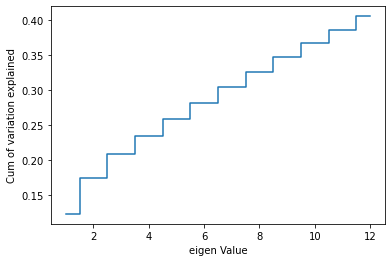

In [64]:
# PCA: using the df_base dataset that does not include the importance based reduction
# The idea is evaluate if PCA based reduction performs better than methods we used

# Let's use fresh variables to avoid any confusion or ease of readability 
X_p = df_base.drop('Pass/Fail', axis=1)
y_p = df['Pass/Fail']
X_p = X_p.apply(zscore)

n=12 # I want to try PCA for 50% dimensions of we are able to reduce using other methods 

pca = PCA(n_components=n, random_state=seed)


pca.fit(X_p)   #scaled X_p

# The eigen Values
# print(pca.explained_variance_)

# The eigen Vector
# print(pca.components_)

# percentage of variation explained by each eigen Vector
print(pca.explained_variance_ratio_)

# Lets visualize cumulative variations explained

plt.step(list(range(1,13)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

<b>Based on my comments in earlier section, I will NOT use PCA </b>


<span style="color:green"><b>MODELING & TUNING STEPS </b></span>

- Step1: Standard algorithms
- Step 2: Cross validation
- Step 3: Compare model performance metrics
- Step 4: Apply Hyper tuning
- Step 5: Compare model performance metrics after Hyper Tuning & run on test dataset

###### I will use the best  model on unseen data for prediction

#### <span style="color:red">Standard algorithms & accuracy on test data</span>

In [65]:
# Instantiating the base models that I will use for this project.

nb = GaussianNB()
logreg = LogisticRegression(solver='liblinear', random_state=seed)
svmc = SVC(C=3, gamma=0.025, random_state=seed)
knn = KNeighborsClassifier(n_neighbors=5)
dtree = DecisionTreeClassifier(random_state=seed)
ada = AdaBoostClassifier( n_estimators= 50, random_state=seed)
bag = BaggingClassifier(base_estimator=dtree, n_estimators=50, max_samples=.7, random_state=seed)
rf = RandomForestClassifier(random_state=seed)


#  will test both with and without cross validations

# I will try both GridSearch and RandomSearch for Hyper Tuning

#### <span style="color:green">Training & Testing models</span>

 <span style="color:red"><b>run_model</b> function</span>
  - I have written this custom function to build, train, test models and generate performance report
  - I am using custom function since this project involves testing many models, and it's easier this way
  
<span style="color:green">Below steps will build, train & test various models</span>
 - I will display performance metrics for each model
 - Howevet, will detailed comparison and observations after running all
 - Based on detailed comparison of performance, I will decide Hyper Tuning strategy


Model Type:  GaussianNB()


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.6385110587466154

F1-score (Mean: K-fold):
0.709409728386516

Accuracy (Mean: K-fold):
0.7394088669950739

Precision (Mean: K-fold):
0.7988659588905239

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 0.748
Accuracy for test set: 0.845



              precision    recall  f1-score   support

          -1       0.98      0.85      0.91       448
           1       0.20      0.74      0.32        23

    accuracy                           0.85       471
   macro avg       0.59      0.79      0.62       471
weighted avg       0.95      0.85      0.88       471



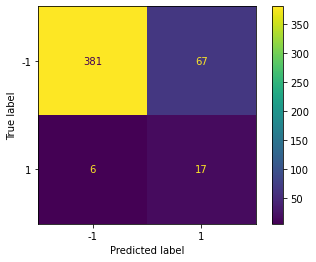

In [66]:
# Naive Bayes with SMOTE OverSampling

perf_summary_df = run_model(perf_summary_df, X_train_o_sm, X_test, y_train_o_sm, y_test, nb, "Naive Bayes", "OverSampling SMOTE","None", num_folds=num_folds, seed=seed)


Model Type:  GaussianNB()


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.6267541154497677

F1-score (Mean: K-fold):
0.6781475852435604

Accuracy (Mean: K-fold):
0.715719696969697

Precision (Mean: K-fold):
0.7554978354978354

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 0.747
Accuracy for test set: 0.779



              precision    recall  f1-score   support

          -1       0.98      0.78      0.87       448
           1       0.15      0.74      0.25        23

    accuracy                           0.78       471
   macro avg       0.57      0.76      0.56       471
weighted avg       0.94      0.78      0.84       471



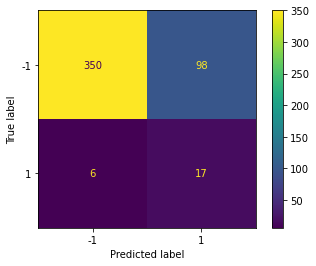

In [67]:
# Naive Bayes with RANDOM UnderSampling

perf_summary_df = run_model(perf_summary_df, X_train_u_r, X_test, y_train_u_r, y_test, nb, "Naive Bayes", "UnderSampling RANDOM", "None",num_folds=num_folds, seed=seed)


Model Type:  GaussianNB()


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.7941354297876037

F1-score (Mean: K-fold):
0.7926340326340326

Accuracy (Mean: K-fold):
0.7901515151515152

Precision (Mean: K-fold):
0.7982745324850588

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 0.846
Accuracy for test set: 0.594



              precision    recall  f1-score   support

          -1       0.98      0.58      0.73       448
           1       0.09      0.83      0.17        23

    accuracy                           0.59       471
   macro avg       0.54      0.70      0.45       471
weighted avg       0.94      0.59      0.70       471



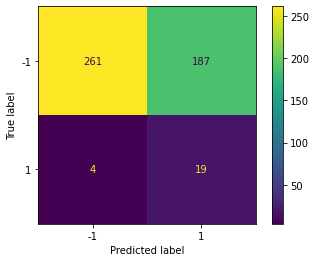

In [68]:
# Naive Bayes with CENTROID UnderSampling

perf_summary_df = run_model(perf_summary_df, X_train_u_c, X_test, y_train_u_c, y_test, nb, "Naive Bayes", "UnderSampling CENTROID", "None",num_folds=num_folds, seed=seed)


Model Type:  LogisticRegression(random_state=7, solver='liblinear')


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.7879002938245929

F1-score (Mean: K-fold):
0.7880411860416552

Accuracy (Mean: K-fold):
0.7881773399014779

Precision (Mean: K-fold):
0.7887333189604899

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 0.794
Accuracy for test set: 0.777



              precision    recall  f1-score   support

          -1       0.98      0.78      0.87       448
           1       0.14      0.70      0.23        23

    accuracy                           0.78       471
   macro avg       0.56      0.74      0.55       471
weighted avg       0.94      0.78      0.84       471



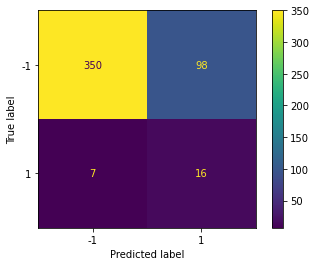

In [69]:
# Logistic Regression with SMOTE OverSampling
perf_summary_df = run_model(perf_summary_df, X_train_o_sm, X_test, y_train_o_sm, y_test, logreg, "Logistic Regression", "OverSampling SMOTE", "None",num_folds=num_folds, seed=seed)


Model Type:  LogisticRegression(random_state=7, solver='liblinear')


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.6392216479173001

F1-score (Mean: K-fold):
0.6278600968923549

Accuracy (Mean: K-fold):
0.6416666666666666

Precision (Mean: K-fold):
0.6794934640522876

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 0.778
Accuracy for test set: 0.745



              precision    recall  f1-score   support

          -1       0.98      0.75      0.85       448
           1       0.13      0.74      0.22        23

    accuracy                           0.75       471
   macro avg       0.56      0.74      0.53       471
weighted avg       0.94      0.75      0.82       471



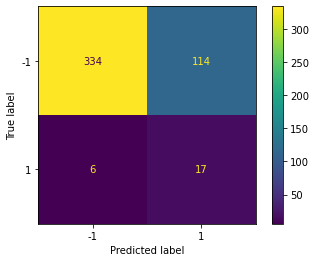

In [70]:
# Logistic Regression with RANDOM UnderSampling
perf_summary_df = run_model(perf_summary_df, X_train_u_r, X_test, y_train_u_r, y_test, logreg, "Logistic Regression", "UnderSampling RANDOM", "None",num_folds=num_folds, seed=seed)


Model Type:  LogisticRegression(random_state=7, solver='liblinear')


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.7272792424966338

F1-score (Mean: K-fold):
0.7290010079483762

Accuracy (Mean: K-fold):
0.740719696969697

Precision (Mean: K-fold):
0.7597985347985349

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 0.796
Accuracy for test set: 0.732



              precision    recall  f1-score   support

          -1       0.98      0.73      0.84       448
           1       0.13      0.78      0.22        23

    accuracy                           0.73       471
   macro avg       0.56      0.76      0.53       471
weighted avg       0.94      0.73      0.81       471



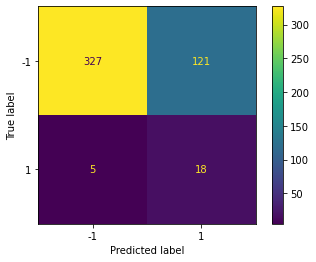

In [71]:
# Logistic Regression with CENTROID UnderSampling

perf_summary_df = run_model(perf_summary_df, X_train_u_c, X_test, y_train_u_c, y_test, logreg, "Logistic Regression", "UnderSampling CENTROID", "None",num_folds=num_folds, seed=seed)


Model Type:  SVC(C=3, gamma=0.025, random_state=7)


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.9959796093053797

F1-score (Mean: K-fold):
0.9583628755513971

Accuracy (Mean: K-fold):
0.9566502463054187

Precision (Mean: K-fold):
0.9236827072898051

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 0.983
Accuracy for test set: 0.913



              precision    recall  f1-score   support

          -1       0.97      0.94      0.95       448
           1       0.24      0.35      0.28        23

    accuracy                           0.91       471
   macro avg       0.60      0.64      0.62       471
weighted avg       0.93      0.91      0.92       471



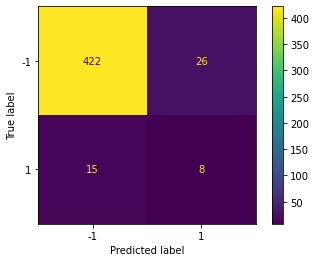

In [72]:
# Support Vector Machine with SMOTE OverSampling
perf_summary_df = run_model(perf_summary_df, X_train_o_sm, X_test, y_train_o_sm, y_test, svmc, "Support Vector Machine", "OverSampling SMOTE", "None",num_folds=num_folds, seed=seed)


Model Type:  SVC(C=3, gamma=0.025, random_state=7)


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.7185623072579594

F1-score (Mean: K-fold):
0.712544891640867

Accuracy (Mean: K-fold):
0.721780303030303

Precision (Mean: K-fold):
0.740343137254902

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 0.957
Accuracy for test set: 0.741



              precision    recall  f1-score   support

          -1       0.99      0.74      0.84       448
           1       0.13      0.78      0.23        23

    accuracy                           0.74       471
   macro avg       0.56      0.76      0.54       471
weighted avg       0.94      0.74      0.81       471



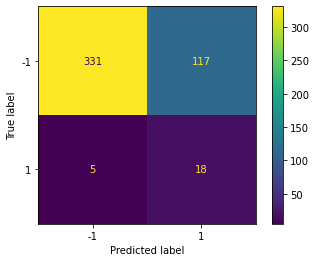

In [73]:
# Support Vector Machine with RANDOM UnderSampling
perf_summary_df = run_model(perf_summary_df, X_train_u_r, X_test, y_train_u_r, y_test, svmc, "Support Vector Machine", "UnderSampling RANDOM", "None",num_folds=num_folds, seed=seed)


Model Type:  SVC(C=3, gamma=0.025, random_state=7)


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.7661421187508144

F1-score (Mean: K-fold):
0.8083559339211513

Accuracy (Mean: K-fold):
0.8210227272727273

Precision (Mean: K-fold):
0.870962370962371

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 0.981
Accuracy for test set: 0.641



              precision    recall  f1-score   support

          -1       0.98      0.64      0.77       448
           1       0.09      0.70      0.16        23

    accuracy                           0.64       471
   macro avg       0.53      0.67      0.47       471
weighted avg       0.93      0.64      0.74       471



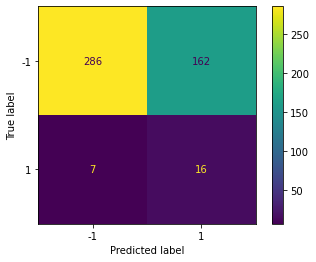

In [74]:
# Support Vector Machine with CENTROID UnderSampling

perf_summary_df = run_model(perf_summary_df, X_train_u_c, X_test, y_train_u_c, y_test, svmc, "Support Vector Machine", "UnderSampling CENTROID", "None",num_folds=num_folds, seed=seed)


Model Type:  KNeighborsClassifier()


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
1.0

F1-score (Mean: K-fold):
0.8867514746614369

Accuracy (Mean: K-fold):
0.8724137931034482

Precision (Mean: K-fold):
0.7966390796649705

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 0.909
Accuracy for test set: 0.781



              precision    recall  f1-score   support

          -1       0.98      0.79      0.87       448
           1       0.14      0.65      0.23        23

    accuracy                           0.78       471
   macro avg       0.56      0.72      0.55       471
weighted avg       0.94      0.78      0.84       471



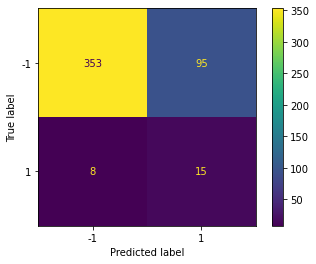

In [75]:


# K-Nearest Neighbors with SMOTE OverSampling
perf_summary_df = run_model(perf_summary_df, X_train_o_sm, X_test, y_train_o_sm, y_test, knn, "K-Nearest Neighbors", "OverSampling SMOTE", "None",num_folds=num_folds, seed=seed)


Model Type:  KNeighborsClassifier()


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.38512530947313556

F1-score (Mean: K-fold):
0.49984639016897087

Accuracy (Mean: K-fold):
0.6361742424242424

Precision (Mean: K-fold):
0.795

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 0.747
Accuracy for test set: 0.866



              precision    recall  f1-score   support

          -1       0.97      0.89      0.93       448
           1       0.18      0.48      0.26        23

    accuracy                           0.87       471
   macro avg       0.57      0.68      0.59       471
weighted avg       0.93      0.87      0.89       471



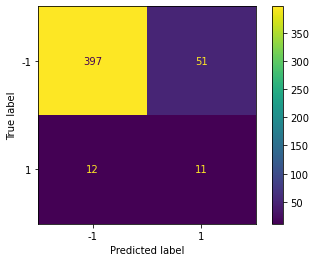

In [76]:
# K-Nearest Neighbors with RANDOM UnderSampling
perf_summary_df = run_model(perf_summary_df, X_train_u_r, X_test, y_train_u_r, y_test, knn, "K-Nearest Neighbors", "UnderSampling RANDOM", "None",num_folds=num_folds, seed=seed)


Model Type:  KNeighborsClassifier()


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.3006510880423924

F1-score (Mean: K-fold):
0.43566130800146147

Accuracy (Mean: K-fold):
0.6295454545454545

Precision (Mean: K-fold):
0.9333333333333333

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 0.704
Accuracy for test set: 0.964



              precision    recall  f1-score   support

          -1       0.97      0.99      0.98       448
           1       0.69      0.48      0.56        23

    accuracy                           0.96       471
   macro avg       0.83      0.73      0.77       471
weighted avg       0.96      0.96      0.96       471



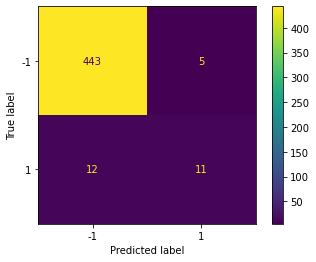

In [77]:
# K-Nearest Neighbors with CENTROID UnderSampling
perf_summary_df = run_model(perf_summary_df, X_train_u_c, X_test, y_train_u_c, y_test, knn, "K-Nearest Neighbors", "UnderSampling CENTROID", "None",num_folds=num_folds, seed=seed)


Model Type:  DecisionTreeClassifier(random_state=7)


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.9053793079878878

F1-score (Mean: K-fold):
0.8794881151623389

Accuracy (Mean: K-fold):
0.8763546798029556

Precision (Mean: K-fold):
0.8557174541190091

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 1.0
Accuracy for test set: 0.854



              precision    recall  f1-score   support

          -1       0.96      0.88      0.92       448
           1       0.13      0.35      0.19        23

    accuracy                           0.85       471
   macro avg       0.55      0.61      0.55       471
weighted avg       0.92      0.85      0.88       471



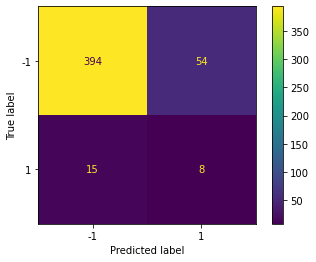

In [78]:
# Decision Tree with SMOTE OverSampling
perf_summary_df = run_model(perf_summary_df, X_train_o_sm, X_test, y_train_o_sm, y_test, dtree, "Decision Tree", "OverSampling SMOTE", "None",num_folds=num_folds, seed=seed)


Model Type:  DecisionTreeClassifier(random_state=7)


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.6896112583069105

F1-score (Mean: K-fold):
0.6586091733256418

Accuracy (Mean: K-fold):
0.6539772727272728

Precision (Mean: K-fold):
0.6624836601307188

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 1.0
Accuracy for test set: 0.694



              precision    recall  f1-score   support

          -1       0.97      0.70      0.81       448
           1       0.10      0.65      0.17        23

    accuracy                           0.69       471
   macro avg       0.54      0.67      0.49       471
weighted avg       0.93      0.69      0.78       471



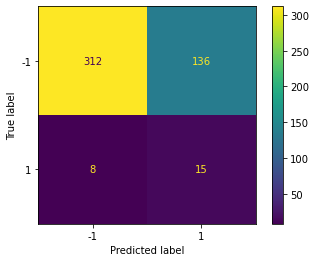

In [79]:
# Decision Tree with RANDOM UnderSampling
perf_summary_df = run_model(perf_summary_df, X_train_u_r, X_test, y_train_u_r, y_test, dtree, "Decision Tree", "UnderSampling RANDOM", "None",num_folds=num_folds, seed=seed)


Model Type:  DecisionTreeClassifier(random_state=7)


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.7201893758415497

F1-score (Mean: K-fold):
0.7523143143143143

Accuracy (Mean: K-fold):
0.7714015151515151

Precision (Mean: K-fold):
0.8000940236234353

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 1.0
Accuracy for test set: 0.546



              precision    recall  f1-score   support

          -1       0.97      0.54      0.69       448
           1       0.07      0.70      0.13        23

    accuracy                           0.55       471
   macro avg       0.52      0.62      0.41       471
weighted avg       0.93      0.55      0.67       471



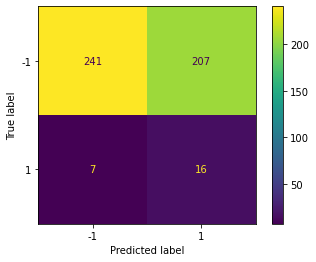

In [80]:
# Decision Tree with CENTROID UnderSampling
perf_summary_df = run_model(perf_summary_df, X_train_u_c, X_test, y_train_u_c, y_test, dtree, "Decision Tree", "UnderSampling CENTROID", "None",num_folds=num_folds, seed=seed)


Model Type:  AdaBoostClassifier(random_state=7)


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.8698939740505468

F1-score (Mean: K-fold):
0.8641284865959491

Accuracy (Mean: K-fold):
0.8630541871921181

Precision (Mean: K-fold):
0.8588251167337949

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 0.896
Accuracy for test set: 0.824



              precision    recall  f1-score   support

          -1       0.97      0.84      0.90       448
           1       0.14      0.52      0.22        23

    accuracy                           0.82       471
   macro avg       0.56      0.68      0.56       471
weighted avg       0.93      0.82      0.87       471



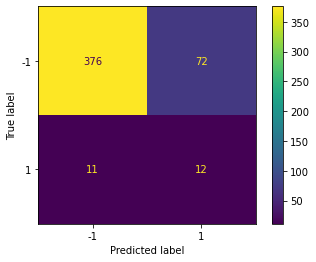

In [81]:
# Adaptive Boosting with SMOTE OverSampling
perf_summary_df = run_model(perf_summary_df, X_train_o_sm, X_test, y_train_o_sm, y_test, ada, "Adaptive Boosting", "OverSampling SMOTE", "None",num_folds=num_folds, seed=seed)


Model Type:  AdaBoostClassifier(random_state=7)


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.6790331407722713

F1-score (Mean: K-fold):
0.6614766081871346

Accuracy (Mean: K-fold):
0.6791666666666667

Precision (Mean: K-fold):
0.6858749437696805

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 1.0
Accuracy for test set: 0.737



              precision    recall  f1-score   support

          -1       0.97      0.75      0.84       448
           1       0.10      0.52      0.16        23

    accuracy                           0.74       471
   macro avg       0.53      0.63      0.50       471
weighted avg       0.93      0.74      0.81       471



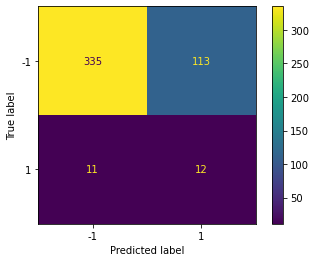

In [82]:
# Adaptive Boosting with RANDOM UnderSampling
perf_summary_df = run_model(perf_summary_df, X_train_u_r, X_test, y_train_u_r, y_test, ada, "Adaptive Boosting", "UnderSampling RANDOM", "None",num_folds=num_folds, seed=seed)


Model Type:  AdaBoostClassifier(random_state=7)


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.7419975676497417

F1-score (Mean: K-fold):
0.7610674606411616

Accuracy (Mean: K-fold):
0.7837121212121212

Precision (Mean: K-fold):
0.8011355311355312

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 1.0
Accuracy for test set: 0.541



              precision    recall  f1-score   support

          -1       0.98      0.53      0.69       448
           1       0.07      0.74      0.14        23

    accuracy                           0.54       471
   macro avg       0.53      0.64      0.41       471
weighted avg       0.93      0.54      0.66       471



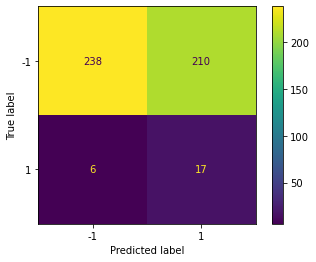

In [83]:
# Adaptive Boosting with CENTROID UnderSampling
perf_summary_df = run_model(perf_summary_df, X_train_u_c, X_test, y_train_u_c, y_test, ada, "Adaptive Boosting", "UnderSampling CENTROID", "None",num_folds=num_folds, seed=seed)


Model Type:  BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=7),
                  max_samples=0.7, n_estimators=50, random_state=7)


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.9616256609194416

F1-score (Mean: K-fold):
0.9485610633621089

Accuracy (Mean: K-fold):
0.9477832512315271

Precision (Mean: K-fold):
0.9358977246983538

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 1.0
Accuracy for test set: 0.928



              precision    recall  f1-score   support

          -1       0.97      0.95      0.96       448
           1       0.32      0.43      0.37        23

    accuracy                           0.93       471
   macro avg       0.65      0.69      0.67       471
weighted avg       0.94      0.93      0.

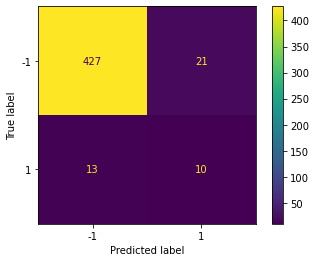

In [84]:
# Bootstrap Agg with SMOTE OverSampling
perf_summary_df = run_model(perf_summary_df, X_train_o_sm, X_test, y_train_o_sm, y_test, bag, "Bootstrap Agg", "OverSampling SMOTE", "None",num_folds=num_folds, seed=seed)


Model Type:  BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=7),
                  max_samples=0.7, n_estimators=50, random_state=7)


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.649427094644486

F1-score (Mean: K-fold):
0.6535118829236476

Accuracy (Mean: K-fold):
0.6662878787878788

Precision (Mean: K-fold):
0.6946031746031747

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 0.994
Accuracy for test set: 0.779



              precision    recall  f1-score   support

          -1       0.98      0.78      0.87       448
           1       0.15      0.74      0.25        23

    accuracy                           0.78       471
   macro avg       0.57      0.76      0.56       471
weighted avg       0.94      0.78      0

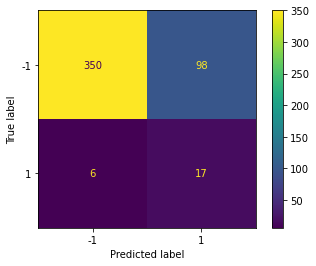

In [85]:
# Bootstrap Agg with RANDOM UnderSampling
perf_summary_df = run_model(perf_summary_df, X_train_u_r, X_test, y_train_u_r, y_test, bag, "Bootstrap Agg", "UnderSampling RANDOM", "None",num_folds=num_folds, seed=seed)


Model Type:  BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=7),
                  max_samples=0.7, n_estimators=50, random_state=7)


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.769470095122269

F1-score (Mean: K-fold):
0.8108807134894092

Accuracy (Mean: K-fold):
0.8274621212121211

Precision (Mean: K-fold):
0.8656675110235481

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 0.988
Accuracy for test set: 0.512



              precision    recall  f1-score   support

          -1       0.98      0.50      0.66       448
           1       0.08      0.83      0.14        23

    accuracy                           0.51       471
   macro avg       0.53      0.66      0.40       471
weighted avg       0.94      0.51      0

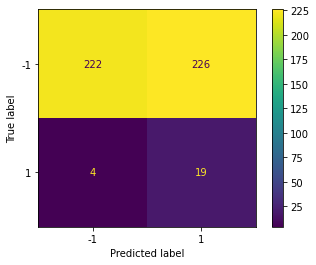

In [86]:
# Bootstrap Agg with CENTROID UnderSampling
perf_summary_df = run_model(perf_summary_df, X_train_u_c, X_test, y_train_u_c, y_test, bag, "Bootstrap Agg", "UnderSampling CENTROID", "None",num_folds=num_folds, seed=seed)


Model Type:  RandomForestClassifier(random_state=7)


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.9834052258394049

F1-score (Mean: K-fold):
0.976566863950912

Accuracy (Mean: K-fold):
0.9763546798029556

Precision (Mean: K-fold):
0.9699730940423674

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 1.0
Accuracy for test set: 0.938



              precision    recall  f1-score   support

          -1       0.96      0.97      0.97       448
           1       0.35      0.30      0.33        23

    accuracy                           0.94       471
   macro avg       0.66      0.64      0.65       471
weighted avg       0.93      0.94      0.94       471



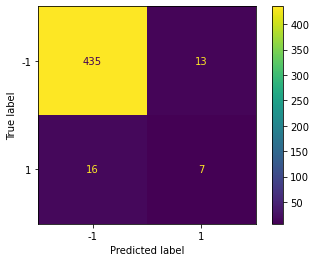

In [87]:
# Random Forest with SMOTE OverSampling
perf_summary_df = run_model(perf_summary_df, X_train_o_sm, X_test, y_train_o_sm, y_test, rf, "Random Forest", "OverSampling SMOTE", "None",num_folds=num_folds, seed=seed)


Model Type:  RandomForestClassifier(random_state=7)


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.6440381357772662

F1-score (Mean: K-fold):
0.6582983193277311

Accuracy (Mean: K-fold):
0.6787878787878788

Precision (Mean: K-fold):
0.7113553113553113

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 1.0
Accuracy for test set: 0.72



              precision    recall  f1-score   support

          -1       0.98      0.72      0.83       448
           1       0.12      0.78      0.21        23

    accuracy                           0.72       471
   macro avg       0.55      0.75      0.52       471
weighted avg       0.94      0.72      0.80       471



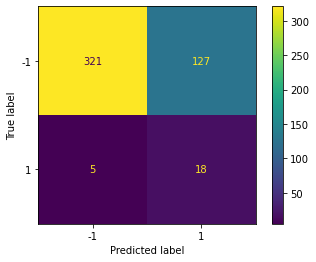

In [88]:
# Random Forest with RANDOM UnderSampling
perf_summary_df = run_model(perf_summary_df, X_train_u_r, X_test, y_train_u_r, y_test, rf, "Random Forest", "UnderSampling RANDOM", "None",num_folds=num_folds, seed=seed)


Model Type:  RandomForestClassifier(random_state=7)


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.8504877730964688

F1-score (Mean: K-fold):
0.853459485795949

Accuracy (Mean: K-fold):
0.8579545454545455

Precision (Mean: K-fold):
0.8620133667502088

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 1.0
Accuracy for test set: 0.469



              precision    recall  f1-score   support

          -1       0.99      0.45      0.62       448
           1       0.07      0.87      0.14        23

    accuracy                           0.47       471
   macro avg       0.53      0.66      0.38       471
weighted avg       0.94      0.47      0.59       471



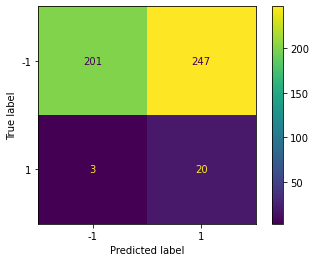

In [89]:
# Random Forest with CENTROID UnderSampling
perf_summary_df = run_model(perf_summary_df, X_train_u_c, X_test, y_train_u_c, y_test, rf, "Random Forest", "UnderSampling CENTROID", "None",num_folds=num_folds, seed=seed)

In [90]:
# Stacking

# Define & setup Stacks

# List of base models
base_models = [("knn",knn) , ("dtree",dtree) , ("svm",svmc)]

# Final Est.
final_est = rf

# Creating meta model
meta = StackingClassifier(estimators=base_models, final_estimator=final_est, cv=5)


Model Type:  StackingClassifier(cv=5,
                   estimators=[('knn', KNeighborsClassifier()),
                               ('dtree',
                                DecisionTreeClassifier(random_state=7)),
                               ('svm', SVC(C=3, gamma=0.025, random_state=7))],
                   final_estimator=RandomForestClassifier(random_state=7))


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.9585762355275517

F1-score (Mean: K-fold):
0.9575811471235806

Accuracy (Mean: K-fold):
0.9576354679802955

Precision (Mean: K-fold):
0.9566642972520712

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 0.994
Accuracy for test set: 0.932



              precision    recall  f1-score   support

          -1       0.96      0.96      

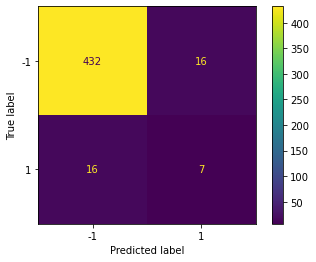

In [91]:
# Stacking with SMOTE OverSampling
perf_summary_df = run_model(perf_summary_df, X_train_o_sm, X_test, y_train_o_sm, y_test, meta, "Stacking", "OverSampling SMOTE", "None",num_folds=num_folds, seed=seed)


Model Type:  StackingClassifier(cv=5,
                   estimators=[('knn', KNeighborsClassifier()),
                               ('dtree',
                                DecisionTreeClassifier(random_state=7)),
                               ('svm', SVC(C=3, gamma=0.025, random_state=7))],
                   final_estimator=RandomForestClassifier(random_state=7))


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.593768405507536

F1-score (Mean: K-fold):
0.5851181498240322

Accuracy (Mean: K-fold):
0.6104166666666667

Precision (Mean: K-fold):
0.6283516483516484

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 0.759
Accuracy for test set: 0.643



              precision    recall  f1-score   support

          -1       0.97      0.65      0

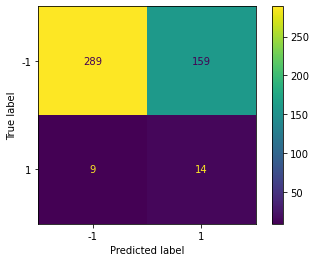

In [92]:
# Stacking with RANDOM UnderSampling
perf_summary_df = run_model(perf_summary_df, X_train_u_r, X_test, y_train_u_r, y_test, meta, "Stacking", "UnderSampling RANDOM", "None",num_folds=num_folds, seed=seed)


Model Type:  StackingClassifier(cv=5,
                   estimators=[('knn', KNeighborsClassifier()),
                               ('dtree',
                                DecisionTreeClassifier(random_state=7)),
                               ('svm', SVC(C=3, gamma=0.025, random_state=7))],
                   final_estimator=RandomForestClassifier(random_state=7))


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.7760178951483299

F1-score (Mean: K-fold):
0.7628596690665657

Accuracy (Mean: K-fold):
0.7647727272727273

Precision (Mean: K-fold):
0.7724918631420179

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 0.975
Accuracy for test set: 0.544



              precision    recall  f1-score   support

          -1       0.98      0.53      

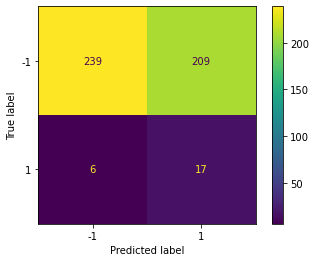

In [93]:
# Stacking with CENTROID UnderSampling
perf_summary_df = run_model(perf_summary_df, X_train_u_c, X_test, y_train_u_c, y_test, meta, "Stacking", "UnderSampling CENTROID", "None",num_folds=num_folds, seed=seed)

#### <span style="color:red">DETAILED PERFORMANCE REPORT <b>WITHOUT</b> HYPER TUNING</span>

- WITHOUT Hyper Tuning

#### <span style="color:red">COMPARISON APPROACH</span>

- As discussed earlier, the datase has imbalance class issue.
- Hence, Accuracy is not the best choice for performance measurement
- Also, it is important to minimize false prediction of Failure.

#### <span style="color:red">I will consider Recall as the first measure to compare performance</span>

- However, will pick a model that does well on other measurement metrics as well. 

In [94]:
# Performance detail of all models is displayed in below table

# After reviewing this, I will create a summary of top performing of each type

perf_summary_df

,Model Name,Technique,Sampling Strategy,In-sample Accuracy,Out-of-sample Accuracy,Recall,F1 Score,Precision
0,Naive Bayes,None,OverSampling SMOTE,0.748,0.845000,0.739000,0.318000,0.202000
1,Naive Bayes,KFold,OverSampling SMOTE,CV - N/A,0.739409,0.638511,0.709410,0.798866
2,Naive Bayes,None,UnderSampling RANDOM,0.747,0.779000,0.739000,0.246000,0.148000
3,Naive Bayes,KFold,UnderSampling RANDOM,CV - N/A,0.715720,0.626754,0.678148,0.755498
4,Naive Bayes,None,UnderSampling CENTROID,0.846,0.594000,0.826000,0.166000,0.092000
5,Naive Bayes,KFold,UnderSampling CENTROID,CV - N/A,0.790152,0.794135,0.792634,0.798275
6,Logistic Regression,None,OverSampling SMOTE,0.794,0.777000,0.696000,0.234000,0.140000
7,Logistic Regression,KFold,OverSampling SMOTE,CV - N/A,0.788177,0.787900,0.788041,0.788733
8,Logistic Regression,None,UnderSampling RANDOM,0.778,0.745000,0.739000,0.221000,0.130000
9,Logistic Regression,KFold,UnderSampling RANDOM,CV - N/A,0.641667,0.639222,0.627860,0.679493


#### <span style="color:red">TOP PERFORMANCE REPORT <b>WITHOUT</b> HYPER TUNING</span>

- WITHOUT Hyper Tuning

In [95]:
# Listing best performing models of each type (More focus on Recall, as explained in earlier section)

# After carefully examining the detailed performance report above, I will now summarize: 

   # For each model type, selecting the best performing model without Hyper Tuning.
   # For top performing models, I will apply Hyper Tuning as next step.

perf_summary_sort_df = perf_summary_df.sort_values(by=["Model Name", "Recall"], ascending=False)
perf_summary_sort_df.reset_index(inplace=True, drop=True)
unique_models = list(perf_summary_sort_df["Model Name"].unique())
rows = pd.DataFrame(columns=perf_summary_sort_df.columns)
for val in unique_models:
    first_idx = perf_summary_sort_df[perf_summary_sort_df["Model Name"] == val].first_valid_index()
    rows.loc[len(rows.index)] = perf_summary_sort_df.loc[first_idx]
rows.sort_values("Recall", ascending=False)   
rows 

,Model Name,Technique,Sampling Strategy,In-sample Accuracy,Out-of-sample Accuracy,Recall,F1 Score,Precision
0,Support Vector Machine,KFold,OverSampling SMOTE,CV - N/A,0.956650,0.995980,0.958363,0.923683
1,Stacking,KFold,OverSampling SMOTE,CV - N/A,0.957635,0.958576,0.957581,0.956664
2,Random Forest,KFold,OverSampling SMOTE,CV - N/A,0.976355,0.983405,0.976567,0.969973
3,Naive Bayes,None,UnderSampling CENTROID,0.846,0.594000,0.826000,0.166000,0.092000
4,Logistic Regression,KFold,OverSampling SMOTE,CV - N/A,0.788177,0.787900,0.788041,0.788733
5,K-Nearest Neighbors,KFold,OverSampling SMOTE,CV - N/A,0.872414,1.000000,0.886751,0.796639
6,Decision Tree,KFold,OverSampling SMOTE,CV - N/A,0.876355,0.905379,0.879488,0.855717
7,Bootstrap Agg,KFold,OverSampling SMOTE,CV - N/A,0.947783,0.961626,0.948561,0.935898
8,Adaptive Boosting,KFold,OverSampling SMOTE,CV - N/A,0.863054,0.869894,0.864128,0.858825


#### <span style="color:green">My Take-away and Next steps</span>

The folliwing models performed very well: across all measurements

 - SVM with K-fold validation and OverSampling using SMOTE
 - Stacking with K-fold validation and OverSampling using SMOTE (Base: knn, decision tree, svm. Final Est. Random Forest)
 - Random Forest with K-fold validation and OverSampling using SMOTE

#### <span style="color:red">KNN happens score 1 for Recall (highest). However, it did poor on all other measurements.</span>

As expected (please refer to comments in earlier sections):
#### <span style="color:red">OverSampling worked much better than UnderSampling</span>

As expected (please refer to comments in earlier sections):
#### <span style="color:blue">No need to try PCA if without PCA we are able to get such high performancr</span>

#### <span style="color:green">Apply Hyper Tuning</span>

TWO CHOICES:
 1. Pick the best performing models and apply Hyper Tuning to see if performance can be improved further
 2. Try to Hyper Tune each model type

<span style="color:red">I will pick choice 2 listed above for the purpose of this project </span>
 - Will use both GridSearch and RandomizedSearch

#### Hypertuning
Models can have many hyperparameters and finding the best combination of parameters can be treated as a search problem. Two best strategies for Hyperparameter tuning are:

GridSearchCV
RandomizedSearchCV
In GridSearchCV approach, machine learning model is evaluated for a range of hyperparameter values. This approach is called GridSearchCV, because it searches for best set of hyperparameters from a grid of hyperparameters values. This technique constructs many versions of the model with all possible combinations of hyerparameters, and returns the best one. This which makes grid search computationally very expensive.

RandomizedSearchCV solves the drawbacks of GridSearchCV, as it goes through only a fixed number of hyperparameter settings. It moves within the grid in random fashion to find the best set hyperparameters. This approach reduces unnecessary computation.

I will try both GridSearchCV & RandomizedSearchCV and compare.

In [96]:
# List all avaiable Hyper Tuning parameters

for clf, label in zip([logreg , svmc, knn, dtree, rf, bag, ada], 
    ['Logistic Regression' , 'Support Vector Machine', 'K-Nearest neighbors', 'Decision Tree', 'Random Forest', 
     'Bootstrap Agg', 'Adaptive Boosting']):
    print("\n*****model name*****: " , label)
    print(f"\nHyper parameters:\n{clf.get_params()}", end="\n\n")


*****model name*****:  Logistic Regression

Hyper parameters:
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 7, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


*****model name*****:  Support Vector Machine

Hyper parameters:
{'C': 3, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.025, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 7, 'shrinking': True, 'tol': 0.001, 'verbose': False}


*****model name*****:  K-Nearest neighbors

Hyper parameters:
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


*****model name*****:  Decision Tree

Hyper parameters:
{'ccp_alpha': 0.0, 'class_weight': None, 'criter

In [97]:
# Writing notes for my own purpose to keep things organized and efficiently code writing

#Hyper Tuning steps I will use
    # Creating the hyperparameter grid (param_dist)
    # Instantiating model classifier
    # Instantiating RandomizedSearchCV object
    # Train / Fit the model
    # Print the tuned parameters and score
    # print best parameters and various performance scores 
    # re-run predictions based on grid object just like with a normal model.: grid_predictions = grid.predict(X_test)

In [98]:
# Defining grids that I will use for each model.

# Defining grids / space in one section for ease of review and central control of any changes

# Logistic Regression:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_vals = [100, 10, 1.0, 0.1, 0.01]
logreg_grid = {"solver": solvers, "penalty": penalty, "C": c_vals}

# K-Nearest Neighbor
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
dist_metric = ['euclidean', 'manhattan', 'minkowski']
knn_grid = {"n_neighbors": n_neighbors,"weights": weights,"metric": dist_metric}

# Support Vector Machine
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
svmc_grid = dict(kernel=kernel,C=C,gamma=gamma)
svmc_grid = {"kernel": kernel,"C": C,"gamma": gamma}

# Bootstrap Agg
n_estimators = [10, 20, 50]
bag_grid = {"n_estimators": n_estimators}

# Random Forest:
n_estimators = [10, 50, 100]
max_features = ['sqrt', 'log2']
rf_grid = {"n_estimators": n_estimators,"max_features": max_features}

# Decision Tree: 
dtree_rnd = {"max_depth": [3, None], 
              "max_features": randint(1, 9), 
              "min_samples_leaf": randint(1, 9), 
              "criterion": ["gini", "entropy"]} 

dtree_grid = {"max_depth": [3, None], 
              "max_features": list(range(1, 10)), 
              "min_samples_leaf": list(range(1, 10)), 
              "criterion": ["gini", "entropy"]} 

#### <span style="color:red">GridSearch Hyper Tuning</span>

 - Applying GridSearch to all models discussed in earlier section for Hyper tuning


Model Type:  GridSearchCV(error_score=0,
             estimator=LogisticRegression(random_state=7, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='recall')


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.8278576979812643

F1-score (Mean: K-fold):
0.8020328760183656

Accuracy (Mean: K-fold):
0.7955665024630542

Precision (Mean: K-fold):
0.7780807196128755

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 0.828
Accuracy for test set: 0.739



              precision    recall  f1-score   support

          -1       0.98      0.76      0.85       448
           1       0.13      0.7

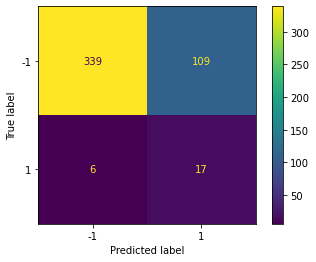

In [99]:
# Logistic Regression:

# Instantiating GridSearchCV object:
gs = GridSearchCV(estimator=logreg, param_grid=logreg_grid, n_jobs=-1, scoring='recall',error_score=0)

perf_summary_df = run_model(perf_summary_df, X_train_o_sm, X_test, y_train_o_sm, y_test, gs, "Logistic Regression", "OverSampling SMOTE", "Hyper - GridSearch",num_folds=num_folds, seed=seed)

gs.fit(X_train_o_sm, y_train_o_sm)

print("\n\nThe best parameters:\n")
print(gs.best_params_)
print("\n\nThe best estimator:\n")
print(gs.best_estimator_)


Model Type:  GridSearchCV(error_score=0, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': range(1, 21, 2),
                         'weights': ['uniform', 'distance']},
             scoring='recall')


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.9990243902439024

F1-score (Mean: K-fold):
0.9242502239717627

Accuracy (Mean: K-fold):
0.9182266009852217

Precision (Mean: K-fold):
0.8600023018943788

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 1.0
Accuracy for test set: 0.565



              precision    recall  f1-score   support

          -1       0.97      0.86      0.91       448
           1       0.17      0.57      0.26   

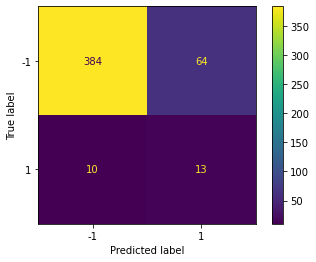

In [100]:
# K-Nearest Neighbor
    
# Instantiating GridSearchCV object:
gs = GridSearchCV(estimator=knn, param_grid=knn_grid, n_jobs=-1, scoring='recall',error_score=0)

perf_summary_df = run_model(perf_summary_df, X_train_o_sm, X_test, y_train_o_sm, y_test, gs, "K-Nearest Neighbors", "OverSampling SMOTE", "Hyper - GridSearch",num_folds=num_folds, seed=seed)

gs.fit(X_train_o_sm, y_train_o_sm)
print("\n\nThe best parameters:\n")
print(gs.best_params_)
print("\n\nThe best estimator:\n")
print(gs.best_estimator_)


Model Type:  GridSearchCV(error_score=0, estimator=SVC(C=3, gamma=0.025, random_state=7),
             n_jobs=-1,
             param_grid={'C': [50, 10, 1.0, 0.1, 0.01], 'gamma': ['scale'],
                         'kernel': ['poly', 'rbf', 'sigmoid']},
             scoring='recall')


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.9990291262135923

F1-score (Mean: K-fold):
0.9764592860132535

Accuracy (Mean: K-fold):
0.9758620689655173

Precision (Mean: K-fold):
0.9549451385497785

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 1.0
Accuracy for test set: 0.304



              precision    recall  f1-score   support

          -1       0.96      0.96      0.96       448
           1       0.30      0.30      0.30        23

    accuracy      

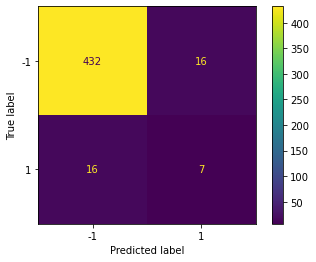

In [101]:
# Support Vector Machine

# Instantiating GridSearchCV object:
gs = GridSearchCV(estimator=svmc, param_grid=svmc_grid, n_jobs=-1, scoring='recall',error_score=0)

perf_summary_df = run_model(perf_summary_df, X_train_o_sm, X_test, y_train_o_sm, y_test, gs, "Support Vector Machine", "OverSampling SMOTE", "Hyper - GridSearch",num_folds=num_folds, seed=seed)

gs.fit(X_train_o_sm, y_train_o_sm)
print("\n\nThe best parameters:\n")
print(gs.best_params_)
print("\n\nThe best estimator:\n")
print(gs.best_estimator_)


Model Type:  GridSearchCV(error_score=0,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=7),
                                         max_samples=0.7, n_estimators=50,
                                         random_state=7),
             n_jobs=-1, param_grid={'n_estimators': [10, 20, 50]},
             scoring='recall')


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.9616256609194416

F1-score (Mean: K-fold):
0.9485610633621089

Accuracy (Mean: K-fold):
0.9477832512315271

Precision (Mean: K-fold):
0.9358977246983538

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 1.0
Accuracy for test set: 0.435



              precision    recall  f1-score   support

          -1       0.97      0.95      0.96 

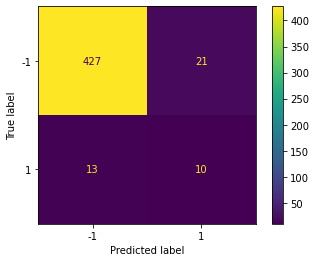

In [102]:
%%time
# Bootstrap Agg

# Instantiating GridSearchCV object:
gs = GridSearchCV(estimator=bag, param_grid=bag_grid, n_jobs=-1, scoring='recall',error_score=0)

perf_summary_df = run_model(perf_summary_df, X_train_o_sm, X_test, y_train_o_sm, y_test, gs, "Bootstrap Agg", "OverSampling SMOTE", "Hyper - GridSearch",num_folds=num_folds, seed=seed)

gs.fit(X_train_o_sm, y_train_o_sm)

print("\n\nThe best parameters:\n")
print(gs.best_params_)
print("\n\nThe best estimator:\n")
print(gs.best_estimator_)


Model Type:  GridSearchCV(error_score=0, estimator=RandomForestClassifier(random_state=7),
             n_jobs=-1,
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 50, 100]},
             scoring='recall')


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.9834052258394049

F1-score (Mean: K-fold):
0.9760987768821054

Accuracy (Mean: K-fold):
0.9758620689655173

Precision (Mean: K-fold):
0.9690480541699593

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 1.0
Accuracy for test set: 0.304



              precision    recall  f1-score   support

          -1       0.96      0.97      0.97       448
           1       0.35      0.30      0.33        23

    accuracy                           0.

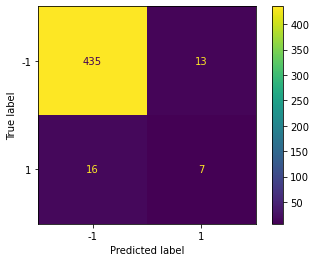

In [103]:
# Random Forest:

# Instantiating GridSearchCV object:
gs = GridSearchCV(estimator=rf, param_grid=rf_grid, n_jobs=-1, scoring='recall',error_score=0)

perf_summary_df = run_model(perf_summary_df, X_train_o_sm, X_test, y_train_o_sm, y_test, gs, "Random Forest", "OverSampling SMOTE", "Hyper - GridSearch",num_folds=num_folds, seed=seed)

gs.fit(X_train_o_sm, y_train_o_sm)
print("\n\nThe best parameters:\n")
print(gs.best_params_)
print("\n\nThe best estimator:\n")
print(gs.best_estimator_)


Model Type:  GridSearchCV(error_score=0, estimator=DecisionTreeClassifier(random_state=7),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, None],
                         'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='recall')


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.9390687306171289

F1-score (Mean: K-fold):
0.7069489415737878

Accuracy (Mean: K-fold):
0.6108374384236454

Precision (Mean: K-fold):
0.5671241003763227

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 0.974
Accuracy for test set: 0.783



              precision    recall  f1-score   support

          -

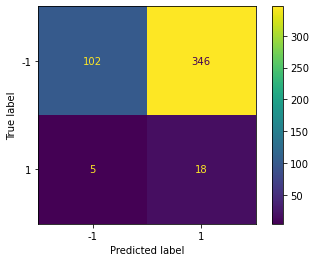

In [104]:
# Decision Tree:

# Instantiating GridSearchCV object:

gs = GridSearchCV(estimator=dtree, param_grid=dtree_grid, n_jobs=-1, scoring='recall',error_score=0)

perf_summary_df = run_model(perf_summary_df, X_train_o_sm, X_test, y_train_o_sm, y_test, gs, "Decision Tree", "OverSampling SMOTE", "Hyper - GridSearch",num_folds=num_folds, seed=seed)

gs.fit(X_train_o_sm, y_train_o_sm)
print("\n\nThe best parameters:\n")
print(gs.best_params_)
print("\n\nThe best estimator:\n")
print(gs.best_estimator_)

#### <span style="color:red">RandomizedSearch Hyper tuning</span>

 - Applying GridSearch to all models discussed in earlier section for Hyper tuning


Model Type:  RandomizedSearchCV(error_score=0,
                   estimator=DecisionTreeClassifier(random_state=7), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa29dd72220>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa29dd72e20>},
                   scoring='recall')


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.9197028014576262

F1-score (Mean: K-fold):
0.7381932553187192

Accuracy (Mean: K-fold):
0.6137931034482758

Precision (Mean: K-fold):
0.5785903892838498

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

------------------------------------

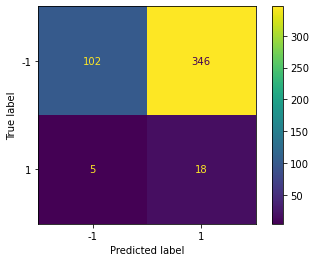

In [105]:
# Decision Tree

# Instantiating RandomizedSearchCV object:
rs = RandomizedSearchCV(dtree, dtree_rnd, n_jobs=-1, scoring='recall', error_score=0) 

perf_summary_df = run_model(perf_summary_df, X_train_o_sm, X_test, y_train_o_sm, y_test, rs, "Decision Tree", "OverSampling SMOTE", "Hyper - RandomSearch",num_folds=num_folds, seed=seed)

rs.fit(X_train_o_sm, y_train_o_sm)
print("\n\nThe best parameters:\n")
print(rs.best_params_)
print("\n\nThe best estimator:\n")
print(rs.best_estimator_)


Model Type:  RandomizedSearchCV(error_score=0,
                   estimator=LogisticRegression(random_state=7,
                                                solver='liblinear'),
                   n_jobs=-1,
                   param_distributions={'C': [100, 10, 1.0, 0.1, 0.01],
                                        'penalty': ['l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   scoring='recall')


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.8190772101763862

F1-score (Mean: K-fold):
0.8000557116882602

Accuracy (Mean: K-fold):
0.7926108374384236

Precision (Mean: K-fold):
0.7820853476355529

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy f

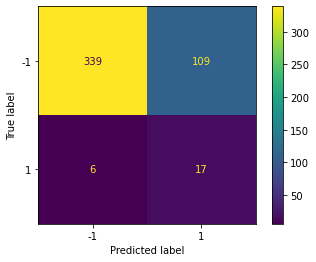

In [106]:
# Logistic Regression:

# Instantiating RandomizedSearchCV object:
rs = RandomizedSearchCV(logreg, logreg_grid, n_jobs=-1, scoring='recall',error_score=0)

perf_summary_df = run_model(perf_summary_df, X_train_o_sm, X_test, y_train_o_sm, y_test, rs, "Logistic Regression", "OverSampling SMOTE", "Hyper - RandomSearch",num_folds=num_folds, seed=seed)

rs.fit(X_train_o_sm, y_train_o_sm)
print("\n\nThe best parameters:\n")
print(rs.best_params_)
print("\n\nThe best estimator:\n")
print(rs.best_estimator_)


Model Type:  RandomizedSearchCV(error_score=0, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan',
                                                   'minkowski'],
                                        'n_neighbors': range(1, 21, 2),
                                        'weights': ['uniform', 'distance']},
                   scoring='recall')


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
1.0

F1-score (Mean: K-fold):
0.8952124394450858

Accuracy (Mean: K-fold):
0.8866995073891625

Precision (Mean: K-fold):
0.8314314833259997

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 1.0
Accuracy for test set: 0.696



              precision    recall  f1-score   support

       

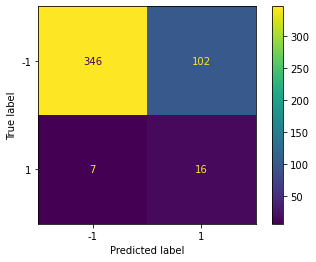

In [107]:
# K-Nearest Neighbors:

# Instantiating RandomizedSearchCV object:
rs = RandomizedSearchCV(knn, knn_grid, n_jobs=-1, scoring='recall',error_score=0)

perf_summary_df = run_model(perf_summary_df, X_train_o_sm, X_test, y_train_o_sm, y_test, rs, "K-Nearest Neighbors", "OverSampling SMOTE", "Hyper - RandomSearch",num_folds=num_folds, seed=seed)

rs.fit(X_train_o_sm, y_train_o_sm)
print("\n\nThe best parameters:\n")
print(rs.best_params_)
print("\n\nThe best estimator:\n")
print(rs.best_estimator_)


Model Type:  RandomizedSearchCV(error_score=0,
                   estimator=SVC(C=3, gamma=0.025, random_state=7), n_jobs=-1,
                   param_distributions={'C': [50, 10, 1.0, 0.1, 0.01],
                                        'gamma': ['scale'],
                                        'kernel': ['poly', 'rbf', 'sigmoid']},
                   scoring='recall')


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.9990291262135923

F1-score (Mean: K-fold):
0.9143727720183426

Accuracy (Mean: K-fold):
0.9753694581280788

Precision (Mean: K-fold):
0.952415211362317

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 1.0
Accuracy for test set: 0.304



              precision    recall  f1-score   support

          -1       0.96      0.97      0

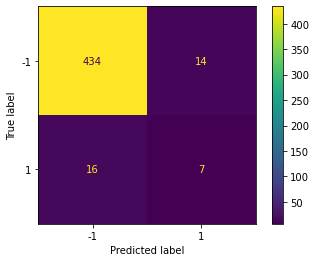

In [108]:
# Support Vector Machine

# Instantiating RandomizedSearchCV object:
rs = RandomizedSearchCV(svmc, svmc_grid, n_jobs=-1, scoring='recall',error_score=0)

perf_summary_df = run_model(perf_summary_df, X_train_o_sm, X_test, y_train_o_sm, y_test, rs, "Support Vector Machine", "OverSampling SMOTE", "Hyper - RandomSearch",num_folds=num_folds, seed=seed)

rs.fit(X_train_o_sm, y_train_o_sm)
print("\n\nThe best parameters:\n")
print(rs.best_params_)
print("\n\nThe best estimator:\n")
print(rs.best_estimator_)


Model Type:  RandomizedSearchCV(error_score=0,
                   estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=7),
                                               max_samples=0.7, n_estimators=50,
                                               random_state=7),
                   n_jobs=-1,
                   param_distributions={'n_estimators': [10, 20, 50]},
                   scoring='recall')


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.9616256609194416

F1-score (Mean: K-fold):
0.9485610633621089

Accuracy (Mean: K-fold):
0.9477832512315271

Precision (Mean: K-fold):
0.9358977246983538

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 1.0
Accuracy for test set: 0.435



              precision    recall  

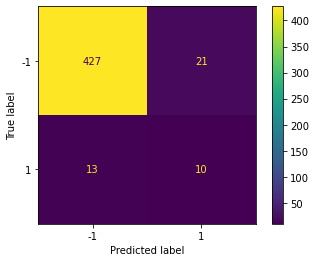

In [109]:
# Bootstrap Agg

# Instantiating RandomizedSearchCV object:
rs = RandomizedSearchCV(bag, bag_grid, n_jobs=-1, scoring='recall',error_score=0)

perf_summary_df = run_model(perf_summary_df, X_train_o_sm, X_test, y_train_o_sm, y_test, rs, "Bootstrap Agg", "OverSampling SMOTE", "Hyper - RandomSearch",num_folds=num_folds, seed=seed)

rs.fit(X_train_o_sm, y_train_o_sm)
print("\n\nThe best parameters:\n")
print(rs.best_params_)
print("\n\nThe best estimator:\n")
print(rs.best_estimator_)


Model Type:  RandomizedSearchCV(error_score=0,
                   estimator=RandomForestClassifier(random_state=7), n_jobs=-1,
                   param_distributions={'max_features': ['sqrt', 'log2'],
                                        'n_estimators': [10, 50, 100]},
                   scoring='recall')


********** MODEL PERFORMANCE METRICS WITH CROSS VALIDATION **********

------------------------------------------------------------------------


Recall (Mean: K-fold):
0.9834052258394049

F1-score (Mean: K-fold):
0.9760987768821054

Accuracy (Mean: K-fold):
0.9758620689655173

Precision (Mean: K-fold):
0.9690480541699593

********** MODEL PERFORMANCE METRICS WITHOUT CROSS VALIDATION**********

---------------------------------------------------------------------


Accuracy for train set: 1.0
Accuracy for test set: 0.304



              precision    recall  f1-score   support

          -1       0.96      0.97      0.97       448
           1       0.35      0.30      0.33     

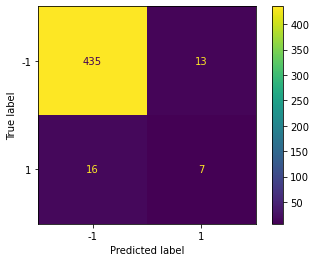

In [110]:
# Random Forest:

# Instantiating RandomizedSearchCV object:
rs = RandomizedSearchCV(rf, rf_grid, n_jobs=-1, scoring='recall',error_score=0)
perf_summary_df = run_model(perf_summary_df, X_train_o_sm, X_test, y_train_o_sm, y_test, rs, "Random Forest", "OverSampling SMOTE", "Hyper - RandomSearch",num_folds=num_folds, seed=seed)


rs.fit(X_train_o_sm, y_train_o_sm)
print("\n\nThe best parameters:\n")
print(rs.best_params_)
print("\n\nThe best estimator:\n")
print(rs.best_estimator_)

#### <span style="color:red">TOP PERFORMANCE REPORT WITH HYPER TUNING</span>

- WITH Hyper Tuning

In [111]:
# Listing best performing models of each type

# For each model type, selecting the best performing model without Hyper Tuning.
# I will use the top performing model to predict Pass/Fail for unseen file in following section 

perf_summary_sort_df = perf_summary_df.sort_values(by=["Model Name", "Recall"], ascending=False)
perf_summary_sort_df.reset_index(inplace=True, drop=True)
unique_models = list(perf_summary_sort_df["Model Name"].unique())
rows = pd.DataFrame(columns=perf_summary_sort_df.columns)
for val in unique_models:
    first_idx = perf_summary_sort_df[perf_summary_sort_df["Model Name"] == val].first_valid_index()
    rows.loc[len(rows.index)] = perf_summary_sort_df.loc[first_idx]
rows   # Printing the top models

,Model Name,Technique,Sampling Strategy,In-sample Accuracy,Out-of-sample Accuracy,Recall,F1 Score,Precision
0,Support Vector Machine,Hyper - GridSearch - KFold,OverSampling SMOTE,CV - N/A,0.975862,0.999029,0.976459,0.954945
1,Stacking,KFold,OverSampling SMOTE,CV - N/A,0.957635,0.958576,0.957581,0.956664
2,Random Forest,KFold,OverSampling SMOTE,CV - N/A,0.976355,0.983405,0.976567,0.969973
3,Naive Bayes,None,UnderSampling CENTROID,0.846,0.594000,0.826000,0.166000,0.092000
4,Logistic Regression,Hyper - GridSearch - KFold,OverSampling SMOTE,CV - N/A,0.795567,0.827858,0.802033,0.778081
5,K-Nearest Neighbors,KFold,OverSampling SMOTE,CV - N/A,0.872414,1.000000,0.886751,0.796639
6,Decision Tree,Hyper - GridSearch - KFold,OverSampling SMOTE,CV - N/A,0.610837,0.939069,0.706949,0.567124
7,Bootstrap Agg,KFold,OverSampling SMOTE,CV - N/A,0.947783,0.961626,0.948561,0.935898
8,Adaptive Boosting,KFold,OverSampling SMOTE,CV - N/A,0.863054,0.869894,0.864128,0.858825


### Performance range with 95% confidence

In [129]:
# Estimating performance range at 95% confidence level for the best model:
svmc = SVC(C=50, random_state=seed)
svmc.fit(X_train_o_sm, y_train_o_sm)
mean_score = np.mean(cross_val_score(svmc, X_train_o_sm, y_train_o_sm, cv=num_folds))
std_scores = np.std(cross_val_score(svmc, X_train_o_sm, y_train_o_sm, cv=num_folds))
interval_95 = [(mean_score - (2*std_scores)), (mean_score + (2*std_scores))]

In [130]:
print(f"With a 95% confidence, the lowest score we will get is: {interval_95[0]}")
print(f"With a 95% confidence, the highest score we will get is: {interval_95[1]}")

With a 95% confidence, the lowest score we will get is: 0.950653169315347
With a 95% confidence, the highest score we will get is: 0.9931891952166729


**`We have 95% confidence that our model will score between 0.95 and 0.99 accuracy`**

#### Let's also look at recall, as we are considering it our most important metric

In [131]:
mean_score_rec = np.mean(cross_val_score(svmc, X_train_o_sm, y_train_o_sm, scoring="recall", cv=num_folds))
std_scores_rec = np.std(cross_val_score(svmc, X_train_o_sm, y_train_o_sm, scoring="recall", cv=num_folds))
interval_95_rec = [(mean_score_rec - (2*std_scores_rec)), (mean_score_rec + (2*std_scores_rec))]

In [132]:
print(f"With a 95% confidence, the lowest score we will get is: {interval_95_rec[0]}")
print(f"With a 95% confidence, the highest score we will get is: {interval_95_rec[1]}")

With a 95% confidence, the lowest score we will get is: 1.0
With a 95% confidence, the highest score we will get is: 1.0


**`We have 95% confidence that our model will not give any False Positives and will have a Recall of 100%`**

### <span style="color:red">FINAL COMPARISON</span>

#### <span style="color:red">COMPARISON APPROACH</span>
* I think that we should not rely on accuracy as our most important metric as this data is highly imbalanced and we could still score very high accuracy if we predict every signal as Pass
* Will use Recall so that we can try to reduce False Positives as much as possible
* I will still pick a model that performs well based on other metrics as well

###### <span style="color:red">RECAP OF PERFORMANCE COMPARISON WITHOUT HYPER TUNING</span>

Copying here for quick reference and ease of comparison with Hyper Tuning results

---
#### <span style="color:green">WITHOUT Hyper Tuning </span>

------------------------------WITHOUT HYPER TUNING-----------------------------------------------------

The folliwing models performed very well: across all measurements

 - SVM with: K-fold validation, OverSampling using SMOTE & Hyper - GridSearch
 - Stacking: with K-fold validation and OverSampling using SMOTE (Base: knn, decision tree, svm. Final Est. Random Forest)
 - Random Forest: with K-fold validation, OverSampling using SMOTE and Hyper - GridSearch

#### <span style="color:red">KNN happens score 1 for Recall (highest). However, it did poor on all other measurements.</span>

As expected (please refer to comments in earlier sections):
#### <span style="color:red">OverSampling worked much better than UnderSampling</span>

As expected (please refer to comments in earlier sections):
#### <span style="color:blue">No need to try PCA if without PCA we are able to get such high performance</span>

---

---
#### <span style="color:green">WITH Hyper Tuning</span>

------------------------------WITH HYPER TUNING-----------------------------------------------------

 
The 3 models that performed very well WITHOUT hypertuning also scored the best WITH hypertuning

#### <span style="color:red">KNN, once again, scores 1 for Recall (highest). However, it did poor on all other measurements.</span>

#### <span style="color:red">We have not applied undersampling during hyperparameter tuning because, as we saw before, most of the models performed better with oversampling, rather than undersampling</span>

#### <span style="color:red">GridSearch worked better than RandomizedSearch for Hyper Tuning</span>

As expected (please refer to comments in earlier sections):
#### <span style="color:blue">Once, again there is no need to apply PCA to the data before feeding it to the models if we are able to get such high scores even without it</span>
---

#### <span style="color:green">BEST MODEL</span>

###### Based on the performance summary above, I consider following model the best model for prediction on unseen data:

 - SVM with K-fold validation and OverSampling using SMOTE
 
 - The best estimator, as displayed in Hyper tuning section while tuning this model: 
   <span style="color:red">SVC(C=50, random_state=7)</span>
 
 <span style="color:green">we will use svm model with above parameters to predict</span>

In [114]:
# Support Vector Machine with SMOTE OverSampling
# Using THE BEST parameter identified in above step (from Hyper tuning & performance comparisons)

# Fit / Train before pickle

svmc = SVC(C=50, random_state=7)
svmc.fit(X_train_o_sm,y_train_o_sm)

SVC(C=50, random_state=7)

#### <span style="color:green">Saving the Model with pickle for future use</span>

- Pickle is the standard way of serializing objects in Python
- We can use the Pickle operation to serialize machine learning algorithms and save the serialized format to a file
- Later we can load this file to deserialize the model and use it to make new predictions

In [115]:
# saving the model to finalized_model.sav in local working directory
filename = 'finalized_model.sav'
pickle.dump(svmc, open(filename, 'wb')) # replace model with the selected model instance name

##### Reading the predictors saved earlier

In [116]:
df_predictors = pd.read_csv('predictor_columns.csv')
features_to_use = list(df_predictors['Column name'])

##### Loading unseen dataset (Future_predictions.xlsx)

In [117]:
# We had already loaded Future_predictions.xlsx, hence no need to load again.
# Adding commands below as comments to summarize how we loaded this file in earlier steps of this project. 

# src_fn2 = 'Future_predictions.xlsx' # Unseen testing set
# df2 = pd.read_excel(src_fn2) # Reading the xlsx data as dataframe

# Let's inspect the first 5 rows again:
df2.head(5)

,Time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100,97.6133,0.1242,1.5005,0.0162,-0.0034,0.9455,202.4396,0,7.9558,414.8710,10.0433,0.9680,192.3963,12.5190,1.4026,-5419.00,2916.50,-4043.75,751.00,0.8955,1.7730,3.0490,64.2333,2.0222,0.1632,3.5191,83.3971,9.5126,50.6170,64.2588,49.3830,66.3141,86.9555,117.5132,61.29,4.515,70,352.7173,10.1841,130.3691,723.3092,1.3072,141.2282,1,624.3145,218.3174,0,4.592,4.841,2834,0.9317,0.9484,4.7057,-1.7264,350.9264,10.6231,108.6427,16.1445,21.7264,29.5367,693.7724,0.9226,148.6009,1,608.1700,84.0793,NaN,NaN,0,0.0126,-0.0206,0.0141,-0.0307,-0.0083,-0.0026,-0.0567,-0.0044,7.2163,0.1320,NaN,2.3895,0.9690,1747.6049,0.1841,8671.9301,-0.3274,-0.0055,-0.0001,0.0001,0.0003,-0.2786,0,0.3974,-0.0251,0.0002,0.0002,0.1350,-0.0042,0.0003,0.0056,0.0000,-0.2468,0.3196,NaN,NaN,NaN,NaN,0.9460,0,748.6115,0.9908,58.4306,0.6002,0.9804,6.3788,15.88,2.639,15.94,15.93,0.8656,3.353,0.4098,3.188,-0.0473,0.7243,0.9960,2.2967,1000.7263,39.2373,123,111.3,75.2,46.2000,350.6710,0.3948,0,6.78,0.0034,0.0898,0.0850,0.0358,0.0328,12.2566,0,4.271,10.284,0.4734,0.0167,11.8901,0.41,0.0506,NaN,NaN,1017,967,1066,368,0.090,0.048,0.095,2.0,0.9,0.069,0.046,0.7250,0.1139,0.3183,0.5888,0.3184,0.9499,0.3979,0.160,0,0,20.95,0.333,12.49,16.713,0.0803,5.72,0,11.19,65.363,0,0,0,0,0,0,0.292,5.38,20.10,0.296,10.62,10.30,5.38,4.040,16.230,0.2951,8.64,0,10.30,97.314,0,0.0772,0.0599,0.0700,0.0547,0.0704,0.0520,0.0301,0.1135,3.4789,0.0010,NaN,0.0707,0.0211,175.2173,0.0315,1940.3994,0,0.0744,0.0546,0,0,0,0,0,0,0,0,0,0.0027,0.0040,0,0,0,0,NaN,NaN,NaN,NaN,0.0188,0,219.9453,0.0011,2.8374,0.0189,0.0050,0.4269,0,0,0,0,0,0,0,0,0,0,0,0.0472,40.855,4.5152,30.9815,33.9606,22.9057,15.9525,110.2144,0.1310,0,2.5883,0.0010,0.0319,0.01

#### Prepare the unseen data

- Drop features that are not being used for predictions
- Scale features

In [118]:
# Separate target and independent variables, Scale the numeric independent features
df2_orig = df2.copy()

for col in df2.columns:
    if col not in features_to_use:
        df2.drop(col, axis=1, inplace=True)

X_unseen = df2.copy()  # select features that are used in the selected model

# Scaling
X_unseen = X_unseen.apply(zscore)

In [119]:
# Let's see top 5 row, before predicting and adding Pass/Fail field

df2.head()

,21,38,59,63,64,65,81,103,121,153,165,197,203,205,216,282,333,343,348,359,425,431,477
0,-5419.00,86.9555,-1.7264,16.1445,21.7264,29.5367,-0.0567,-0.0042,15.88,0.0167,0.095,20.10,16.230,8.64,0.0301,0.0109,6.5893,2.9971,0.0215,0.0229,4.7141,33.1562,5.8142
1,-5441.50,87.5241,0.8073,10.9036,19.1927,27.6301,-0.0377,-0.0045,15.88,0.0144,0.124,19.59,15.078,8.96,0.0734,0.0069,5.9247,2.4890,0.0142,0.0248,6.1188,2.2655,5.8042
2,-5447.75,84.7327,23.8245,11.3019,16.1755,24.2829,-0.0182,-0.0026,15.90,0.0177,0.068,19.75,22.624,13.30,0.0349,0.0075,5.9453,5.6983,0.0105,0.0302,5.2707,29.1663,9.1221
3,-5468.25,86.6867,24.3791,13.5597,15.6209,23.4736,0.0028,-0.0059,15.55,0.0150,0.100,23.60,24.320,9.56,0.0643,0.0063,6.6262,6.3292,0.0407,0.0252,13.4420,13.4051,6.4746
4,-5476.25,86.1468,-12.2945,21.9782,32.2945,44.1498,-0.0123,-0.0045,15.75,0.0126,0.113,15.76,33.832,9.09,0.0924,0.0080,4.7279,6.3767,0.0246,0.0286,4.2892,10.7390,6.1979


##### Load the Pickled model to make predictions on the unseen dataset

In [120]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

y_pred = loaded_model.predict(X_unseen)

df2_orig['Pass_Fail_Predicted']= y_pred

# Let's see top 5 rows with Pass/Fail field populated with predicted value
df2_orig.head()

,Time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,Pass_Fail_Predicted
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100,97.6133,0.1242,1.5005,0.0162,-0.0034,0.9455,202.4396,0,7.9558,414.8710,10.0433,0.9680,192.3963,12.5190,1.4026,-5419.00,2916.50,-4043.75,751.00,0.8955,1.7730,3.0490,64.2333,2.0222,0.1632,3.5191,83.3971,9.5126,50.6170,64.2588,49.3830,66.3141,86.9555,117.5132,61.29,4.515,70,352.7173,10.1841,130.3691,723.3092,1.3072,141.2282,1,624.3145,218.3174,0,4.592,4.841,2834,0.9317,0.9484,4.7057,-1.7264,350.9264,10.6231,108.6427,16.1445,21.7264,29.5367,693.7724,0.9226,148.6009,1,608.1700,84.0793,NaN,NaN,0,0.0126,-0.0206,0.0141,-0.0307,-0.0083,-0.0026,-0.0567,-0.0044,7.2163,0.1320,NaN,2.3895,0.9690,1747.6049,0.1841,8671.9301,-0.3274,-0.0055,-0.0001,0.0001,0.0003,-0.2786,0,0.3974,-0.0251,0.0002,0.0002,0.1350,-0.0042,0.0003,0.0056,0.0000,-0.2468,0.3196,NaN,NaN,NaN,NaN,0.9460,0,748.6115,0.9908,58.4306,0.6002,0.9804,6.3788,15.88,2.639,15.94,15.93,0.8656,3.353,0.4098,3.188,-0.0473,0.7243,0.9960,2.2967,1000.7263,39.2373,123,111.3,75.2,46.2000,350.6710,0.3948,0,6.78,0.0034,0.0898,0.0850,0.0358,0.0328,12.2566,0,4.271,10.284,0.4734,0.0167,11.8901,0.41,0.0506,NaN,NaN,1017,967,1066,368,0.090,0.048,0.095,2.0,0.9,0.069,0.046,0.7250,0.1139,0.3183,0.5888,0.3184,0.9499,0.3979,0.160,0,0,20.95,0.333,12.49,16.713,0.0803,5.72,0,11.19,65.363,0,0,0,0,0,0,0.292,5.38,20.10,0.296,10.62,10.30,5.38,4.040,16.230,0.2951,8.64,0,10.30,97.314,0,0.0772,0.0599,0.0700,0.0547,0.0704,0.0520,0.0301,0.1135,3.4789,0.0010,NaN,0.0707,0.0211,175.2173,0.0315,1940.3994,0,0.0744,0.0546,0,0,0,0,0,0,0,0,0,0.0027,0.0040,0,0,0,0,NaN,NaN,NaN,NaN,0.0188,0,219.9453,0.0011,2.8374,0.0189,0.0050,0.4269,0,0,0,0,0,0,0,0,0,0,0,0.0472,40.855,4.5152,30.9815,33.9606,22.9057,15.9525,110.2144,0.1310,0,2.588

In [121]:
df2_orig["Pass_Fail_Predicted"].value_counts()

-1    17
 1     1
Name: Pass_Fail_Predicted, dtype: int64

### <span style="color:green"> Based on the seen data, the distribution for our predictions appear as we might have expected</span>

#### <span style="color:green">Final Comments</span>

* `EDA and imputations resulted in some information loss, though this could not have been avoided`
* `Detailed performance report was created to include all the relevant performance metrics`
* `Summary performance report was created to compare and determine the best performing model(s)`
* `Pickled the best model and used it to predict Pass or Fail for the unseen data`

## <span style="color:red">END OF PROJECT</span>